In [2]:
# ! pip install pandasql
# !sudo apt update 
# !sudo apt-get install texlive-xetex dvipng texlive-latex-extra texlive-fonts-recommended cm-super

In [87]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pandasql import sqldf

# matplotlib.rcParams['text.usetex'] = True
plt.rc('text.latex', preamble=r'\usepackage{underscore}')
default_backend = matplotlib.get_backend()
print(default_backend)
matplotlib.use(default_backend)

def scientific(x, pos):
    return f'{x}'

from matplotlib.ticker import FuncFormatter

matplotlib.rcParams.update({
            "pgf.texsystem": "xelatex",
            'font.family': 'serif',
            'text.usetex': True,
            'pgf.rcfonts': False,
        })

scientific_formatter = FuncFormatter(scientific)

module://matplotlib_inline.backend_inline


In [4]:
# from google.colab import drive
# drive.mount("/content/gdrive")

In [88]:
# resultsgraphs='/content/gdrive/MyDrive/cylon/generic_patterns_results'
resultsgraphs = '/home/niranda/Desktop/cylon_results/figures'
data_dir = '/home/niranda/Desktop/cylon_results'
cylon =   'Cylon' #'Anon'  #
cflow =   'CylonFlow' #'AnonFlow'  #
colors = {f'{cylon}': 'blue', 
          f'{cylon}_sort': 'royalblue', 
          f'{cylon}_hash': 'cornflowerblue',
          f'{cylon}_mapred_hash': 'royalblue',
          f'{cylon}_range': 'royalblue', 
          f'{cylon}_sample_sort': 'cornflowerblue',
          f'{cflow}-Ray': 'darkorange', 
          f'{cflow}-Dask': 'darkgreen', 
          'Ray': 'brown', 
          'Dask': 'darkblue', 
          'Spark': 'purple', 
          'pandas': 'maroon', 
          'Modin' : 'darkgrey',
          f'{cylon}_mpi': 'cornflowerblue', 
          f'{cylon}_gloo': 'orange', 
          f'{cylon}_ucx': 'green',
          f'Normal': 'blue', 
          f'Op-pipeline': 'darkgreen', 
          f'{cflow}-Parsl_gloo': 'darkorange', 
          f'{cflow}-Parsl_ucx': 'darkgreen'
         }
markers = {f'{cylon}': '.', 
           f'{cylon}_sort': '.', 
          f'{cylon}_hash': '.',
           f'{cylon}_mapred_hash': '.',
        f'{cylon}_range': '.', 
          f'{cylon}_sample_sort': '.',
           f'{cflow}-Ray': 'o', 
           f'{cflow}-Dask': 's', 
           'Ray': 'D', 
           'Dask': 'x', 
           'Spark': '^', 
           'pandas': 'P', 
           'Modin' : '*',
          f'{cylon}_gloo': 'd', 
          f'{cylon}_mpi': 'o', 
          f'{cylon}_ucx': 's',
        f'Normal': '.', 
          f'Op-pipeline': '.', 
          f'{cflow}-Parsl_gloo': 'D', 
          f'{cflow}-Parsl_ucx': 'x' 
          }

def plot(data, out_file, title, just_show, colors=None, speedup=None, mk=markers):
    if just_show:
        matplotlib.use(default_backend)
    else:
        matplotlib.use("pgf")
        matplotlib.rcParams.update({
            "pgf.texsystem": "xelatex",
            'font.family': 'serif',
            'text.usetex': True,
            'pgf.rcfonts': False,
        })
    
    ax = data.plot(x="world", loglog=True, xticks=data['world'], xlabel='parallelism',
                   ylabel='time (ms)',
                   title=title, color=colors)
    
    cols = data.columns[1:]
    for i, line in enumerate(ax.get_lines()): 
        line.set_marker(mk[cols[i]])
        
    ax.legend(ax.get_lines(), cols, loc='best')

    def scientific(x, pos):
        return f'{x}'

    from matplotlib.ticker import FuncFormatter

    scientific_formatter = FuncFormatter(scientific)
    ax.xaxis.set_major_formatter(scientific_formatter)
    
    if speedup is not None:
        ax1=speedup.plot(x='world', ax=ax, secondary_y=True, color=colors, loglog=True, linestyle=':', legend=False, xticks=data['world'])
        ax1.xaxis.set_major_formatter(scientific_formatter)
        ax1.set_ylabel(ylabel='speed-up over pandas')
        ax.set_xlabel(xlabel='parallelism')
    
    if just_show:
        plt.show()
    else:
        plt.savefig(out_file)
        plt.savefig(out_file.replace('pgf', 'png'))
        plt.savefig(out_file.replace('pgf', 'svg'))
        
    

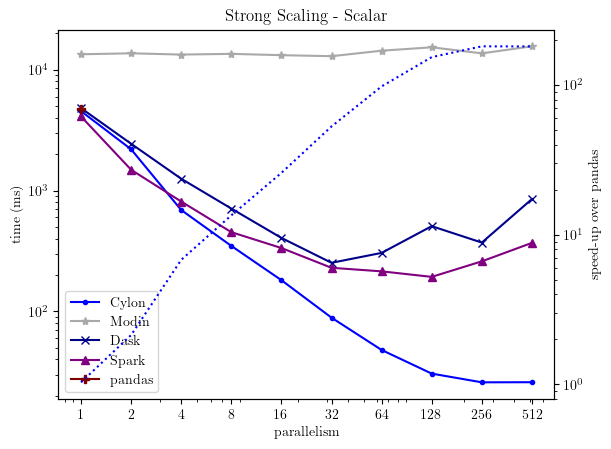

,world,Cylon,Modin,Dask,Spark,pandas
0,1,4541.374207,13423.122168,4807.691514,4104.441431,4692.208827
1,2,2194.870392,13672.823588,2438.960314,1486.158000,NaN
2,4,690.210183,13346.138716,1252.104759,810.962386,NaN
3,8,348.189294,13528.454423,709.594131,452.603234,NaN
4,16,181.226710,13192.312400,405.489564,334.393157,NaN
5,32,88.716745,12942.605098,252.278626,229.423841,NaN
6,64,47.919254,14368.418217,304.822743,214.398146,NaN
7,128,30.546670,15330.747485,507.255077,192.986091,NaN
8,256,25.872074,13655.222575,370.970547,259.494623,NaN
9,512,25.925644,15618.498325,850.136757,368.922909,NaN


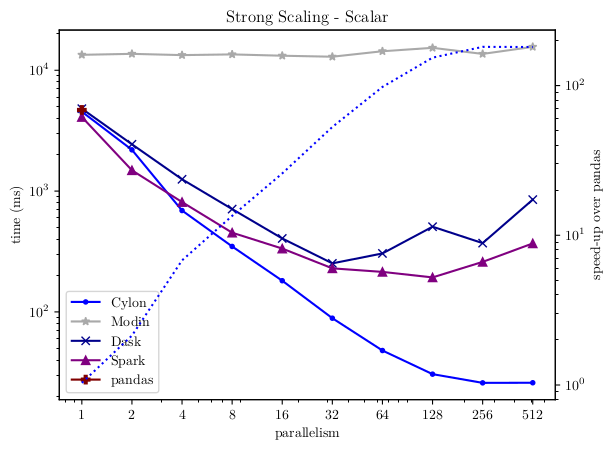

In [45]:
def process_scalar(cy, mod, dask, pandas_, sp, title, out_file, rows, just_show=False):
    cylon_df = pd.read_csv(cy, comment='#')
    modin_df = pd.read_csv(mod, comment='#')
    dask_df = pd.read_csv(dask, comment='#')
    pd_df = pd.read_csv(pandas_, comment='#')
    spark_df = pd.read_csv(sp, comment='#')

    cylon_avg = sqldf(
        f"SELECT world, avg(time) as avg FROM cylon_df WHERE rows={rows} AND tag like '%c=mpi%' AND it!=0 GROUP BY world ORDER BY world", locals())
    modin_avg = sqldf(
        f"SELECT world, avg(time) as avg FROM modin_df WHERE rows={rows} AND it!=0 GROUP BY world ORDER BY world", locals())
    dask_avg = sqldf(
        f"SELECT world, avg(time) as avg FROM dask_df WHERE rows={rows} AND it!=0 GROUP BY world ORDER BY world", locals())
    spark_avg = sqldf(
        f"SELECT world, avg(time) as avg FROM spark_df WHERE rows={rows} AND it!=0 GROUP BY world ORDER BY world", locals())

    data = sqldf(f"""SELECT cy.world, cy.avg AS {cylon}, md.avg AS Modin, da.avg as Dask, sa.avg as Spark 
        FROM cylon_avg cy JOIN modin_avg md ON cy.world = md.world
        JOIN dask_avg da ON da.world = cy.world
        JOIN spark_avg sa ON sa.world = cy.world""", locals())

    pd_avg = sqldf(
        f"SELECT world, avg(time) as avg FROM pd_df WHERE rows={rows} GROUP BY world", locals())
    l = [None for _ in range(len(data))]
    l[0] = pd_avg['avg'][0]
    data['pandas'] = l
    
    speed_up_data = None
    speed_up_data = l[0]/ data[[cylon]]
    speed_up_data['world'] = data['world']
    # speed_up_data = l[0]/ data[[cylon, 'Modin', 'Dask', 'Spark']]
    # speed_up_data['world'] = data['world']

    plot(data, out_file, title, True, colors=colors, speedup=speed_up_data)
    plot(data, out_file, title, False, colors=colors, speedup=speed_up_data)
    
    return data 

just_show = False

process_scalar(f'{data_dir}/scalar.csv', f'{data_dir}/modin_scalar.csv',
               f'{data_dir}/dask_scalar.csv',
               f'{data_dir}/pandas_scalar.csv', 
               f'{data_dir}/spark_scalar.csv', 
               'Strong Scaling - Scalar',
               f'{resultsgraphs}/scalar.pgf', 1000000000, just_show)

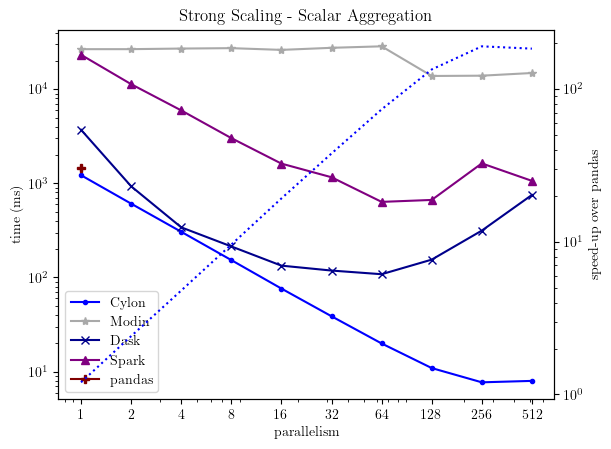

,world,Cylon,Modin,Dask,Spark,pandas
0,1,1221.198559,26658.411026,3712.479989,23236.205286,1466.658545
1,2,608.973940,26657.605410,931.465387,11323.899561,NaN
2,4,305.960596,27051.301003,341.097991,5960.034370,NaN
3,8,153.068423,27322.705030,213.847081,3025.915384,NaN
4,16,76.272060,26188.110828,133.646250,1621.190654,NaN
5,32,38.741348,27551.301718,118.507544,1161.332369,NaN
6,64,19.912666,28573.608875,108.361642,635.901266,NaN
7,128,10.909849,13831.855774,154.821634,666.719198,NaN
8,256,7.697381,13932.038307,315.026919,1630.106052,NaN
9,512,7.971556,14873.846054,753.602346,1063.147757,NaN


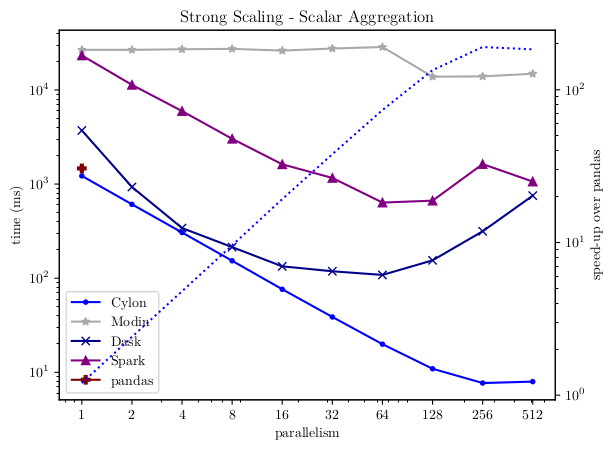

In [30]:
process_scalar(f'{data_dir}/scalar-agg.csv', f'{data_dir}/modin_scalar_agg.csv',
               f'{data_dir}/dask_scalar_agg.csv',
               f'{data_dir}/pandas_scalar_agg.csv',
               f'{data_dir}/spark_scalar_agg.csv', 
               'Strong Scaling - Scalar Aggregation',
               f'{resultsgraphs}/scalar-agg.pgf', 1000000000, just_show)

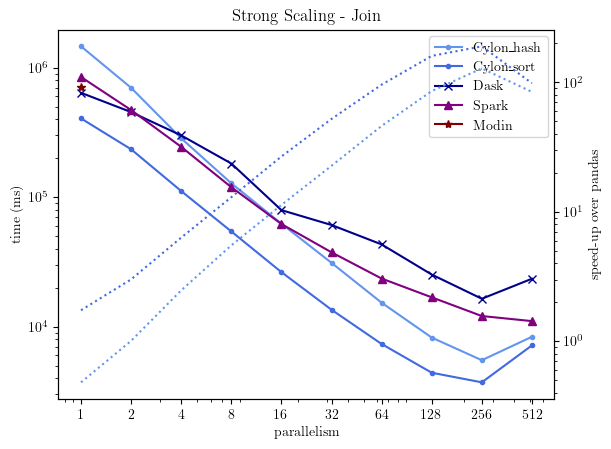

,world,Cylon_hash,Cylon_sort,Dask,Spark,Modin,pandas
0,1,1.461554e+06,405472.273668,639354.469633,847201.018201,None,705125.56994
1,2,6.987131e+05,234145.614584,453845.482397,470407.287783,None,NaN
2,4,2.846024e+05,111409.997602,299640.709698,244510.379394,None,NaN
3,8,1.279309e+05,54322.337757,181818.096352,119308.051851,None,NaN
4,16,6.233578e+04,26345.911642,79360.196066,61998.463601,None,NaN
5,32,3.107066e+04,13498.681961,60906.038046,37469.982439,None,NaN
6,64,1.529324e+04,7340.191923,43124.872589,23506.499979,None,NaN
7,128,8.227437e+03,4402.370871,25231.248903,16829.565346,None,NaN
8,256,5.499268e+03,3711.647179,16408.410597,12065.257788,None,NaN
9,512,8.344229e+03,7156.308946,23420.881081,11024.170187,None,NaN


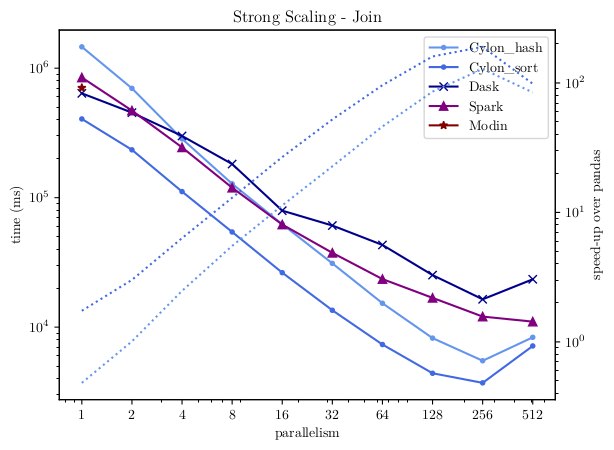

In [35]:
def process_join(cy, mod, dask, spark, pandas_, title, out_file, rows, just_show=False):
    cylon_df = pd.read_csv(cy, comment='#')
    modin_df = pd.read_csv(mod, comment='#')
    dask_df = pd.read_csv(dask, comment='#')
    spark_df = pd.read_csv(spark, comment='#')

    cylon_hash_avg = sqldf(
        f"SELECT world, avg(time) as avg FROM cylon_df WHERE rows={rows} AND tag like '%a=hash u=0.9 c=mpi%' AND it!=0 GROUP BY world",
        locals())
    cylon_sort_avg = sqldf(
        f"SELECT world, avg(time) as avg FROM cylon_df WHERE rows={rows} AND tag like '%a=sort u=0.9 c=mpi%' AND it!=0 GROUP BY world",
        locals())
    modin_avg = sqldf(
        f"SELECT world, avg(time) as avg FROM modin_df WHERE rows={rows} AND it!=0 GROUP BY world", locals())
    dask_avg = sqldf(
        f"SELECT world, avg(time) as avg FROM dask_df WHERE rows={rows} AND it!=0 GROUP BY world", locals())
    spark_avg = sqldf(
        f"SELECT world, avg(time) as avg FROM spark_df WHERE rows={rows} AND it!=0 GROUP BY world", locals())
    

    if len(modin_avg):
        data = sqldf(f"""SELECT cy.world, cy.avg AS {cylon}_hash, cys.avg as {cylon}_sort, md.avg AS Modin, da.avg as Dask, sp.avg as Spark 
          FROM cylon_hash_avg cy 
          JOIN cylon_sort_avg cys ON cy.world = cys.world
          JOIN modin_avg md ON cy.world = md.world
          JOIN dask_avg da ON da.world = cy.world
          JOIN spark_avg sp ON sp.world = cy.world
          """, locals())
    else:
        data = sqldf(f"""SELECT cy.world, cy.avg AS {cylon}_hash, cys.avg as {cylon}_sort, da.avg as Dask, sp.avg as Spark 
          FROM cylon_hash_avg cy 
          JOIN cylon_sort_avg cys ON cy.world = cys.world
          JOIN dask_avg da ON da.world = cy.world
          JOIN spark_avg sp ON sp.world = cy.world
          """, locals())
        data['Modin'] = [None for _ in range(len(data))]
    
    pd_df = pd.read_csv(pandas_, comment='#')
    pd_avg = sqldf(
        f"SELECT world, avg(time) as avg FROM pd_df WHERE rows={rows} GROUP BY world", locals())
    l = [None for _ in range(len(data))]
    l[0] = pd_avg['avg'][0]
    data['pandas'] = l
    
    speed_up_data = None
    speed_up_data = l[0]/ data[[f'{cylon}_sort', f'{cylon}_hash']]
    # speed_up_data = l[0]/ data[[f'{cylon}_sort', f'{cylon}_hash', 'Modin', 'Dask']]
    speed_up_data['world'] = data['world']
    
    # {f'{cylon}_sort': 'royalblue', f'{cylon}_hash': 'cornflowerblue', 'modin': 'orange',
        # 'dask': 'green', 'pandas': 'maroon', 'spark': 'purple'}
    plot(data, out_file, title, True, colors=colors, speedup=speed_up_data)
    plot(data, out_file, title, False, colors=colors, speedup=speed_up_data)
    
    return data

process_join(f'{data_dir}/join.csv', 
             f'{data_dir}/modin_join.csv',
             f'{data_dir}/dask_join.csv',
             f'{data_dir}/spark_join.csv',
             f'{data_dir}/pandas_join.csv', 
             'Strong Scaling - Join',
             f'{resultsgraphs}/join1B.pgf', 1000000000, None)

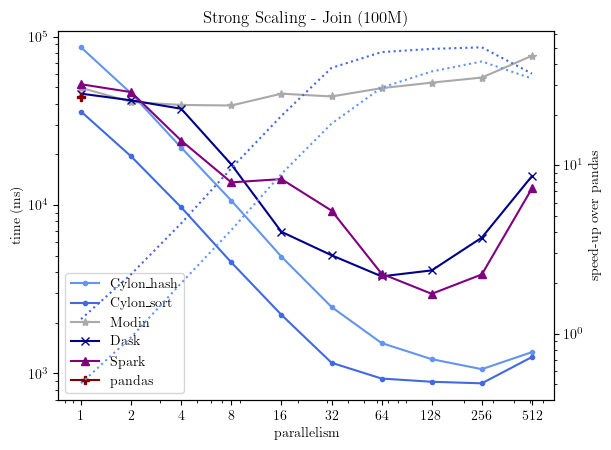

,world,Cylon_hash,Cylon_sort,Modin,Dask,Spark,pandas
0,1,86508.634197,35955.641508,49751.359463,45914.642215,52198.020577,43807.772636
1,2,46067.080366,19470.111797,40994.780064,41901.000321,46890.456498,NaN
2,4,21965.075129,9695.878034,39327.589750,37341.491878,24152.607799,NaN
3,8,10637.190806,4567.248677,39042.614460,17445.756674,13643.049479,NaN
4,16,4938.266269,2229.684319,45885.592937,6938.918209,14266.823649,NaN
5,32,2482.377859,1157.323117,44175.829649,5035.581732,9272.806406,NaN
6,64,1514.591127,932.404771,49488.513470,3772.268438,3910.159051,NaN
7,128,1215.547123,892.309846,53364.571571,4093.422270,2970.829129,NaN
8,256,1059.867303,873.543363,57217.237234,6409.523249,3873.622835,NaN
9,512,1338.252703,1251.473340,77025.178194,14857.713652,12548.650384,NaN


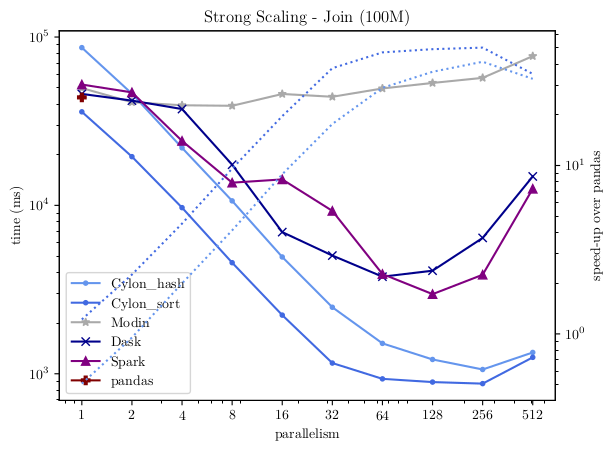

In [36]:
process_join(f'{data_dir}/join.csv', 
             f'{data_dir}/modin_join.csv',
             f'{data_dir}/dask_join.csv',
             f'{data_dir}/spark_join.csv',
             f'{data_dir}/pandas_join.csv', 
             'Strong Scaling - Join (100M)',
             f'{resultsgraphs}/join100M.pgf', 100000000, just_show)

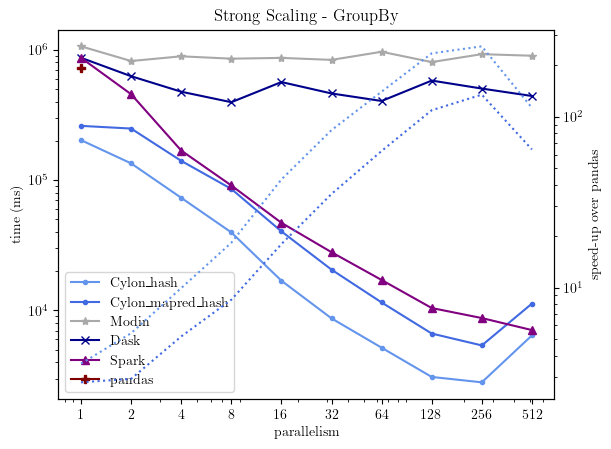

,world,Cylon_hash,Cylon_mapred_hash,Modin,Dask,Spark,pandas
0,1,202661.834038,260672.506843,1.062215e+06,867792.817146,867187.831211,726710.740507
1,2,134376.259191,248568.720545,8.194281e+05,626467.576057,455875.105572,NaN
2,4,73156.346372,140490.461988,8.904780e+05,476520.910025,168586.329365,NaN
3,8,39721.903247,85592.544360,8.539766e+05,395927.389145,90965.979457,NaN
4,16,16916.937158,40436.527391,8.659070e+05,565002.696991,47047.025585,NaN
5,32,8698.396732,20573.009912,8.359693e+05,461991.052945,27981.979084,NaN
6,64,5182.065584,11521.265810,9.646933e+05,404526.781480,17134.374797,NaN
7,128,3091.593603,6654.251071,8.042046e+05,580021.078587,10443.365991,NaN
8,256,2811.534861,5394.329346,9.249890e+05,503697.638512,8746.273756,NaN
9,512,6440.074470,11290.019295,8.995566e+05,441801.900387,7073.992395,NaN


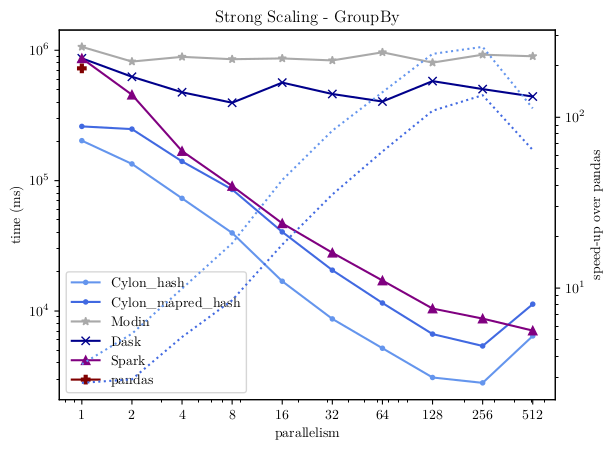

In [150]:
def process_groupby(cy, mod, dask, spark, pandas_, title, out_file, rows, just_show=False):
    cylon_df = pd.read_csv(cy, comment='#')
    modin_df = pd.read_csv(mod, comment='#')
    dask_df = pd.read_csv(dask, comment='#')
    spark_df = pd.read_csv(spark, comment='#')

    cylon_hash_avg = sqldf(f"SELECT world, avg(time) as avg FROM cylon_df WHERE rows={rows} AND tag like '%a=hash u=0.9 c=mpi%' AND it!=0 GROUP BY world", locals())
    cylon_sort_avg = sqldf(f"SELECT world, avg(time) as avg FROM cylon_df WHERE rows={rows} AND tag like '%a=mapred_hash u=0.9 c=mpi%' AND it!=0 GROUP BY world",  locals())
    modin_avg = sqldf(f"SELECT world, avg(time) as avg FROM modin_df WHERE rows={rows} AND it!=0 GROUP BY world", locals())
    dask_avg = sqldf(f"SELECT world, avg(time) as avg FROM dask_df WHERE rows={rows} AND it!=0 GROUP BY world", locals())
    spark_avg = sqldf(f"SELECT world, avg(time) as avg FROM spark_df WHERE rows={rows} AND it!=0 GROUP BY world", locals())

    data = sqldf(f"""SELECT cy.world, cy.avg AS {cylon}_hash, cys.avg as {cylon}_mapred_hash, md.avg AS Modin, da.avg as Dask, sp.avg as Spark 
        FROM cylon_hash_avg cy 
        JOIN cylon_sort_avg cys ON cy.world = cys.world
        LEFT JOIN modin_avg md ON cy.world = md.world
        JOIN dask_avg da ON da.world = cy.world
        JOIN spark_avg sp ON sp.world = cy.world
        """, locals())

    if len(modin_avg) == 0:
        data.drop(columns='Modin', inplace=True)
    
    pd_df = pd.read_csv(pandas_, comment='#')
    pd_avg = sqldf(
        f"SELECT world, avg(time) as avg FROM pd_df WHERE rows={rows} GROUP BY world", locals())
    l = [None for _ in range(len(data))]
    l[0] = pd_avg['avg'][0]
    data['pandas'] = l
    
    speed_up_data = None
    speed_up_data = l[0]/ data[[f'{cylon}_hash', f'{cylon}_mapred_hash']]
    # speed_up_data = l[0]/ data[[f'{cylon}_hash', f'{cylon}_mapred_hash', 'Modin', 'Dask']]
    speed_up_data['world'] = data['world']

    # colors_ = {
    #     f'{cylon}_hash': 'royalblue', f'{cylon}_mapred_hash': 'cornflowerblue', 'modin': 'orange',
    #     'dask': 'green', 'pandas': 'maroon'}
    plot(data, out_file, title, True, colors=colors, speedup=speed_up_data)
    plot(data, out_file, title, False, colors=colors, speedup=speed_up_data)
    
    return data
    
process_groupby(f'{data_dir}/groupby.csv', f'{data_dir}/modin_groupby.csv',
                f'{data_dir}/dask_groupby.csv', 
                f'{data_dir}/spark_groupby.csv', 
                f'{data_dir}/pandas_groupby.csv',
                'Strong Scaling - GroupBy', f'{resultsgraphs}/groupby.pgf',
                1000000000, just_show)

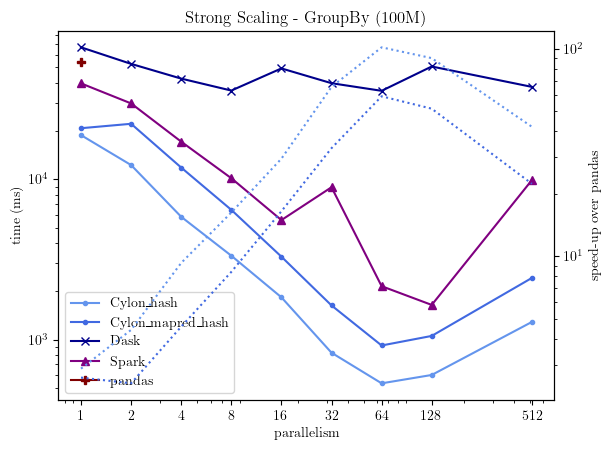

,world,Cylon_hash,Cylon_mapred_hash,Dask,Spark,pandas
0,1,18891.650534,20861.967421,66701.060057,39733.199239,54285.135031
1,2,12284.310317,22232.146668,52576.230192,29785.983205,NaN
2,4,5842.471230,11853.328156,42551.302195,17194.910824,NaN
3,8,3339.900053,6456.132263,35835.504341,10168.967843,NaN
4,16,1837.082002,3293.892977,49259.868145,5572.981596,NaN
5,32,828.850900,1635.203409,39830.006838,8935.988784,NaN
6,64,534.014247,919.651081,35705.991459,2155.990958,NaN
7,128,602.091688,1055.175440,50639.405298,1647.225499,NaN
8,512,1290.093536,2428.211059,37781.612968,9905.106624,NaN


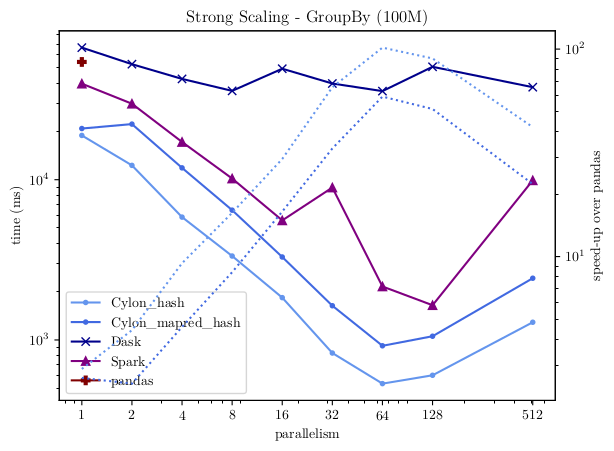

In [151]:
process_groupby(f'{data_dir}/groupby.csv', f'{data_dir}/modin_groupby.csv',
                f'{data_dir}/dask_groupby.csv', 
                f'{data_dir}/spark_groupby.csv', 
                f'{data_dir}/pandas_groupby.csv',
                'Strong Scaling - GroupBy (100M)', f'{resultsgraphs}/groupby_100M.pgf',
                100000000, just_show)

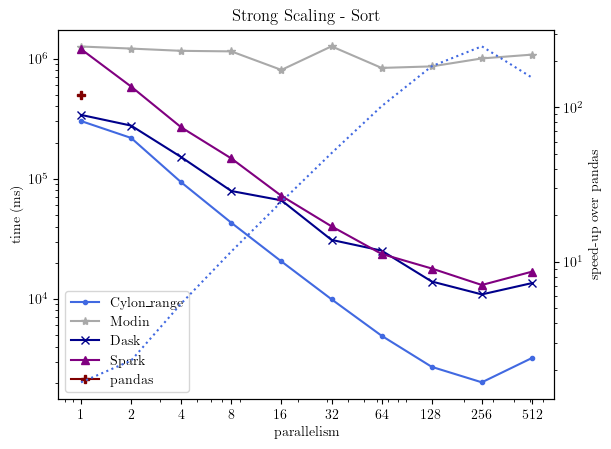

,world,Cylon_range,Modin,Dask,Spark,pandas
0,1,302151.194572,1.261209e+06,339864.141434,1.199813e+06,501213.823318
1,2,218474.884351,1.212072e+06,276807.482302,5.850891e+05,NaN
2,4,93354.044298,1.160679e+06,151344.714483,2.677619e+05,NaN
3,8,42976.905197,1.148705e+06,78995.740334,1.475174e+05,NaN
4,16,20473.858600,8.049457e+05,66045.089483,7.197626e+04,NaN
5,32,9912.570136,1.265642e+06,30947.041829,4.012560e+04,NaN
6,64,4923.994444,8.364980e+05,25181.685527,2.363447e+04,NaN
7,128,2713.072496,8.614094e+05,13932.737112,1.787848e+04,NaN
8,256,2016.478711,1.003412e+06,10879.658381,1.303157e+04,NaN
9,512,3213.600735,1.079341e+06,13513.130665,1.682320e+04,NaN


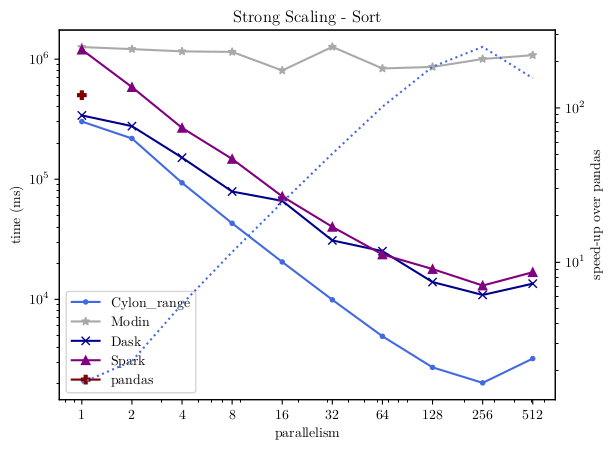

In [146]:
def process_sort(cy, mod, dask, spark, pandas_, title, out_file, rows, just_show=False):
    cylon_df = pd.read_csv(cy, comment='#')
    modin_df = pd.read_csv(mod, comment='#')
    dask_df = pd.read_csv(dask, comment='#')
    spark_df = pd.read_csv(spark, comment='#')

    cylon1 = sqldf(f"SELECT world, avg(time) as avg FROM cylon_df WHERE rows={rows} AND tag like '%a=initial u=0.9 c=mpi%' AND it!=0 GROUP BY world", locals())
    # cylon2 = sqldf(f"SELECT world, avg(time) as avg FROM cylon_df WHERE rows={rows} AND tag like '%a=regular u=0.9 c=mpi%' AND it!=0 GROUP BY world",  locals())
    modin_avg = sqldf(f"SELECT world, avg(time) as avg FROM modin_df WHERE rows={rows} AND it!=0 GROUP BY world", locals())
    dask_avg = sqldf(f"SELECT world, avg(time) as avg FROM dask_df WHERE rows={rows} AND it!=0 GROUP BY world", locals())
    spark_avg = sqldf(f"SELECT world, avg(time) as avg FROM spark_df WHERE rows={rows} AND it!=0 GROUP BY world", locals())

    # data = sqldf(f"""SELECT cy.world, cy.avg AS {cylon}_range, cy2.avg as {cylon}_sample_sort, md.avg AS Modin, da.avg as Dask, sp.avg as Spark 
    #     FROM cylon1 cy 
    #     LEFT JOIN cylon2 cy2 ON cy2.world = cy.world
    #     JOIN modin_avg md ON cy.world = md.world
    #     JOIN dask_avg da ON da.world = cy.world
    #     JOIN spark_avg sp ON sp.world = cy.world
    #     """, locals())
    data = sqldf(f"""SELECT cy.world, cy.avg AS {cylon}_range, md.avg AS Modin, da.avg as Dask, sp.avg as Spark 
        FROM cylon1 cy 
        JOIN dask_avg da ON da.world = cy.world
        JOIN spark_avg sp ON sp.world = cy.world
        LEFT JOIN modin_avg md ON cy.world = md.world
        """, locals())
    
    if len(modin_avg) == 0:
        data.drop(columns='Modin', inplace=True)
    
    pd_df = pd.read_csv(pandas_, comment='#')
    pd_avg = sqldf(
        f"SELECT world, avg(time) as avg FROM pd_df WHERE rows={rows} GROUP BY world", locals())
    l = [None for _ in range(len(data))]
    l[0] = pd_avg['avg'][0]
    data['pandas'] = l
    
    speed_up_data = None
    speed_up_data = l[0]/ data[[f'{cylon}_range']]
    # speed_up_data = l[0]/ data[[f'{cylon}_hash', f'{cylon}_mapred_hash', 'Modin', 'Dask']]
    speed_up_data['world'] = data['world']

    # colors_ = {
    #     f'{cylon}_hash': 'royalblue', f'{cylon}_mapred_hash': 'cornflowerblue', 'modin': 'orange',
    #     'dask': 'green', 'pandas': 'maroon'}
    plot(data, out_file, title, True, colors=colors, speedup=speed_up_data)
    plot(data, out_file, title, False, colors=colors, speedup=speed_up_data)
    
    return data
    
process_sort(f'{data_dir}/sort.csv', f'{data_dir}/modin_sort.csv',
                f'{data_dir}/dask_sort.csv', 
                f'{data_dir}/spark_sort.csv', 
                f'{data_dir}/pandas_sort.csv',
                'Strong Scaling - Sort', f'{resultsgraphs}/sort.pgf',
                1000000000, just_show)

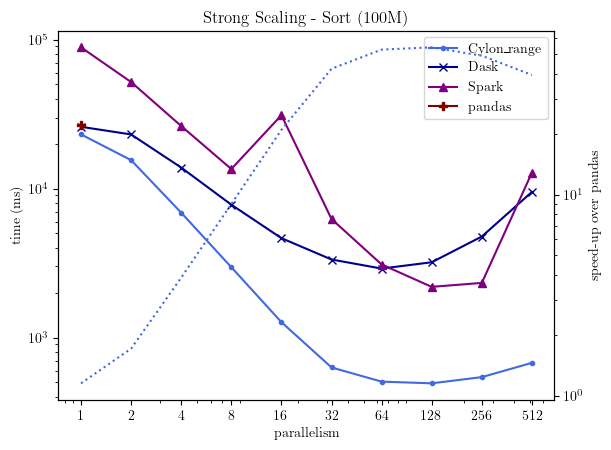

,world,Cylon_range,Dask,Spark,pandas
0,1,23105.733395,25994.086313,88773.207235,26680.957127
1,2,15523.763967,23089.876986,51896.457148,NaN
2,4,6889.577866,13839.812851,26302.621794,NaN
3,8,2966.657847,7797.478151,13525.342226,NaN
4,16,1269.064626,4648.354483,31105.004501,NaN
5,32,629.964459,3341.465902,6249.524307,NaN
6,64,506.033248,2904.659653,3093.390179,NaN
7,128,492.973634,3202.769756,2189.686108,NaN
8,256,542.681311,4766.448689,2327.567387,NaN
9,512,676.397879,9498.931551,12792.009294,NaN


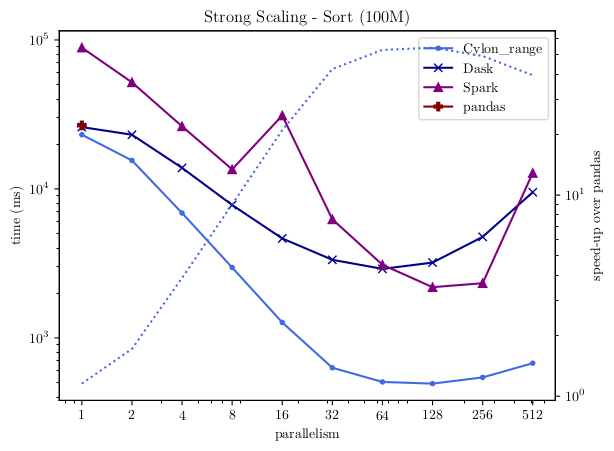

In [147]:
process_sort(f'{data_dir}/sort.csv', f'{data_dir}/modin_sort.csv',
                f'{data_dir}/dask_sort.csv', 
                f'{data_dir}/spark_sort.csv', 
                f'{data_dir}/pandas_sort.csv',
                'Strong Scaling - Sort (100M)', f'{resultsgraphs}/sort_100M.pgf',
                100000000, just_show)

In [235]:
# def process_join(cy, mod, dask, pandas_, spark, title, out_file, rows, just_show=False):
#     cylon_df = pd.read_csv(cy, comment='#')
#     modin_df = pd.read_csv(mod, comment='#')
#     dask_df = pd.read_csv(dask, comment='#')
#     spark_df = pd.read_csv(spark, comment='#')

#     cylon_hash_avg = sqldf(
#         f"SELECT world, avg(time) as avg FROM cylon_df WHERE rows={rows} AND tag like '%a=hash%c=mpi%' AND it!=0  GROUP BY world",
#         locals())
#     cylon_sort_avg = sqldf(
#         f"SELECT world, avg(time) as avg FROM cylon_df WHERE rows={rows} AND tag like '%a=sort%c=mpi%' AND it!=0  GROUP BY world",
#         locals())
#     modin_avg = sqldf(
#         f"SELECT world, avg(time) as avg FROM modin_df WHERE rows={rows} AND it!=0  GROUP BY world", locals())
#     dask_avg = sqldf(
#         f"SELECT world, avg(time) as avg FROM dask_df WHERE rows={rows} AND it!=0  GROUP BY world", locals())
#     spark_avg = sqldf(
#         f"SELECT world, avg(time) as avg FROM spark_df WHERE rows={rows} AND it!=0  GROUP BY world", locals())

#     if len(modin_avg) and len(spark_avg):
#         data = sqldf(f"""SELECT cy.world, cy.avg AS {cylon}_hash, cys.avg as {cylon}_sort, md.avg AS modin, da.avg as dask, sp.avg as spark 
#           FROM cylon_hash_avg cy 
#           JOIN cylon_sort_avg cys ON cy.world = cys.world
#           JOIN modin_avg md ON cy.world = md.world
#           JOIN dask_avg da ON da.world = cy.world
#           JOIN spark_avg sp ON sp.world = cy.world
#           """, locals())
#     else:
#         data = sqldf(f"""SELECT cy.world, cy.avg AS {cylon}_hash, cys.avg as {cylon}_sort, da.avg as dask 
#           FROM cylon_hash_avg cy 
#           JOIN cylon_sort_avg cys ON cy.world = cys.world
#           JOIN dask_avg da ON da.world = cy.world
#           """, locals())
    
#     pd_df = pd.read_csv(pandas_, comment='#')
#     pd_avg = sqldf(
#         f"SELECT world, avg(time) as avg FROM pd_df WHERE rows={rows} GROUP BY world", locals())
#     l = [None for _ in range(len(data))]
#     l[0] = pd_avg['avg'][0]
#     data['pandas'] = l
    
    
#     plot(data, out_file, title, just_show, colors={
#         f'{cylon}_sort': 'royalblue', f'{cylon}_hash': 'cornflowerblue', 'modin': 'orange',
#         'dask': 'green', 'pandas': 'maroon', 'spark': 'purple'})
    
#     return data

# just_show = False

# process_join(f'{data_dir}/join.csv', 
#              f'{data_dir}/modin_join.csv',
#              f'{data_dir}/dask_join.csv',
#              f'{data_dir}/pandas_join.csv', 
#              f'{data_dir}/spark_join.csv',
#              'Strong Scaling - Join',
#              f'{resultsgraphs}/join100M.pgf', 100000000, just_show)

,world,Cylon_hash,Cylon_sort,modin,dask,spark,pandas
0,1,83316.693425,35869.936943,51587.365150,50501.276135,49835.056543,43807.772636
1,2,44328.680217,19347.560874,42809.238434,48071.399152,47387.081570,NaN
2,4,21600.001924,9626.037513,42684.509516,37535.268784,24150.332284,NaN
3,8,10407.711767,4548.435390,43799.168944,23217.902362,12898.120430,NaN
4,16,4924.286222,2220.971039,46046.582222,17500.727475,12975.223568,NaN
5,32,2491.546250,1181.033158,47182.249784,13998.150527,6242.221938,NaN
6,64,1520.925561,941.633531,50466.069698,12497.640908,8145.223061,NaN
7,128,1206.283182,883.752639,54275.367618,14360.000491,9449.057251,NaN
8,256,1034.072459,872.740028,60662.725329,15494.778514,10086.635245,NaN
9,512,1355.524242,1266.962757,78075.039029,24519.382656,10203.271945,NaN


In [37]:
# def process_groupby_cylon(cy, title, out_file, rows, just_show=False):
#     cylon_df = pd.read_csv(cy, comment='#')

#     cylon_hash_09_avg = sqldf(
#         f"SELECT world, avg(time) as avg FROM cylon_df WHERE rows={rows} AND  tag like '%hash%u=0.9%c=mpi%' GROUP BY world",
#         locals())
#     cylon_mapred_09_avg = sqldf(
#         f"SELECT world, avg(time) as avg FROM cylon_df WHERE rows={rows} AND  tag like '%mapred_hash%u=0.9%c=mpi%' GROUP BY world",
#         locals())
#     cylon_hash_1e_avg = sqldf(
#         f"SELECT world, avg(time) as avg FROM cylon_df WHERE rows={rows} AND  tag like '%hash%u=1e-05%c=mpi%' GROUP BY world",
#         locals())
#     cylon_mapred_1e_avg = sqldf(
#         f"SELECT world, avg(time) as avg FROM cylon_df WHERE rows={rows} AND  tag like '%mapred_hash%u=1e-05%c=mpi%' GROUP BY world",
#         locals())

#     data = sqldf("""SELECT cy09.world, cy09.avg AS hash_09, cymap.avg as mapred_09, cy1e.avg AS hash_1e_05, cymap1e.avg as mapred_1e_05 
#         FROM cylon_hash_09_avg cy09 
#         JOIN cylon_mapred_09_avg cymap ON cy09.world = cymap.world
#         JOIN cylon_hash_1e_avg cy1e ON cy09.world = cy1e.world
#         JOIN cylon_mapred_1e_avg cymap1e ON cy09.world = cymap1e.world
#         ORDER BY cy09.world
#         """, locals())

#     data = data.rename(columns={'hash_09': 'hash C=0.9', 'hash_1e_05': 'hash C=1e-5',
#                                 'mapred_09': 'mapred C=0.9', 'mapred_1e_05': 'mapred C=1e-5'})
#     plot(data, out_file, title, just_show, colors={
#         'hash C=0.9': 'tab:blue', 'hash C=1e-5': 'tab:cyan', 'mapred C=0.9': 'tab:red',
#         'mapred C=1e-5': 'tab:pink'})
#     return data

# just_show=False
# process_groupby_cylon(f'{data_dir}/groupby.csv', 'GroupBy Cardinality',
#                       f'{resultsgraphs}/cylon_groupby.pgf',
#                       1000000000, just_show)

,world,hash C=0.9,mapred C=0.9,hash C=1e-5,mapred C=1e-5
0,1,217931.950028,248386.343877,44389.778233,45879.150057
1,2,187210.535096,242133.839634,34229.394317,22397.722578
2,4,104530.576050,137103.021834,16201.852679,10836.735868
3,8,61320.906036,83570.358081,7941.951871,5349.460363
4,16,28244.032731,39713.943212,4345.338774,2961.800814
5,32,14428.550753,20256.206090,2466.096854,1570.641422
6,64,8261.183201,11384.106222,1582.044792,859.790945
7,128,4802.307900,6552.594058,1121.881700,554.372501
8,256,4043.756441,5336.999156,1281.351972,434.055090
9,512,8630.564301,11064.538139,3912.586665,2067.655563


In [ ]:


# process_join(f'{resultsgraphs}/join.csv', f'{resultsgraphs}/modin_join.csv',
#              f'{resultsgraphs}/dask_join.csv',
#              f'{resultsgraphs}/pandas_join.csv', 'Strong Scaling - Join',
#              f'{resultsgraphs}/join100M.pgf', 100000000, just_show)

# process_join(f'{resultsgraphs}/join.csv', f'{resultsgraphs}/modin_join.csv',
#              f'{resultsgraphs}/dask_join.csv', f'{resultsgraphs}/pandas_join.csv',
#              'Strong Scaling - Join', f'{resultsgraphs}/join1B.pgf', 1000000000, just_show)

# process_groupby(f'{resultsgraphs}/groupby.csv', f'{resultsgraphs}/modin_groupby.csv',
#                 f'{resultsgraphs}/dask_groupby.csv', f'{resultsgraphs}/pandas_groupby.csv',
#                 'Strong Scaling - GroupBy', f'{resultsgraphs}/groupby.pgf',
#                 1000000000, just_show)




In [3]:
# def process_join_comms(cy, mod, dask, pandas_, title, out_file, rows, just_show=False):
def process_join_comms(cy, title, out_file, rows, algo='sort'):
    cylon_df = pd.read_csv(cy, comment='#')

    cylon_sort_avg_mpi = sqldf(
        f"SELECT world, avg(time) as avg FROM cylon_df WHERE rows={rows} AND tag like '%a={algo}%c=mpi' AND it!=0 GROUP BY world",
        locals())
    cylon_sort_avg_gloo = sqldf(
        f"SELECT world, avg(time) as avg FROM cylon_df WHERE rows={rows} AND tag like '%a={algo}%c=gloo' AND it!=0 GROUP BY world",
        locals())
    cylon_sort_avg_ucx = sqldf(
        f"SELECT world, avg(time) as avg FROM cylon_df WHERE rows={rows} AND tag like '%a={algo}%c=%ucx' AND it!=0 GROUP BY world",
        locals())

    data = sqldf(
        f"""SELECT cym.world, cym.avg AS {cylon}_mpi, cyg.avg as {cylon}_gloo, cyu.avg AS {cylon}_ucx
          FROM cylon_sort_avg_mpi cym
          JOIN cylon_sort_avg_gloo cyg ON cym.world = cyg.world
          LEFT JOIN cylon_sort_avg_ucx cyu ON cym.world = cyu.world
          """, locals())

    plot(data, out_file, title, True, colors=colors)
    plot(data, out_file, title, False, colors=colors)
    
    return data

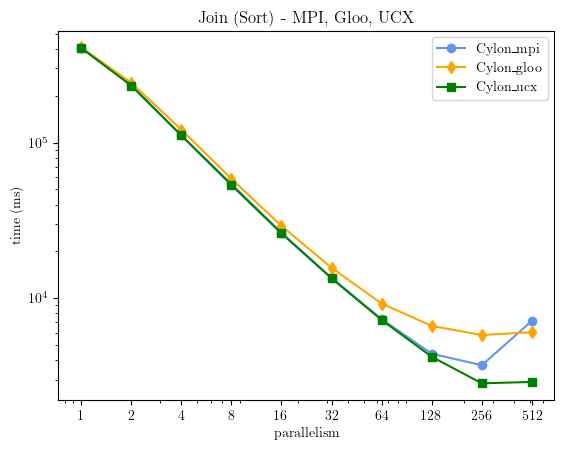

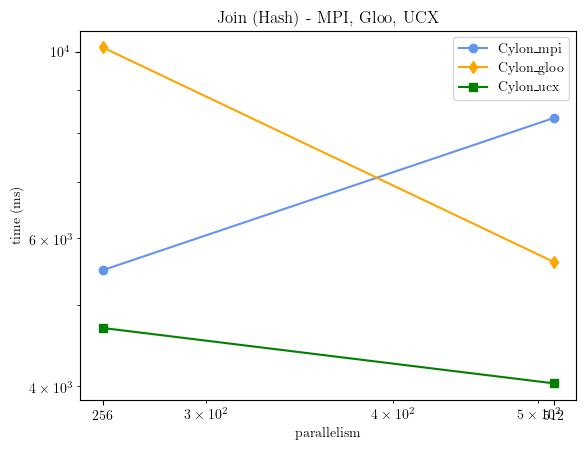

,world,Cylon_mpi,Cylon_gloo,Cylon_ucx
0,256,5499.268404,10130.102127,4694.527547
1,512,8344.229113,5627.605160,4033.581378


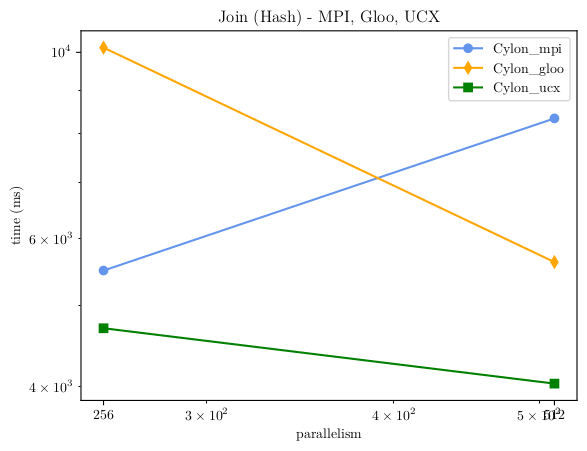

In [96]:
process_join_comms(f'{data_dir}/join.csv', 'Join (Sort) - MPI, Gloo, UCX',
                   f'{resultsgraphs}/cylon_join_comms.pgf', 1000000000)
process_join_comms(f'{data_dir}/join.csv', 'Join (Hash) - MPI, Gloo, UCX',
                   f'{resultsgraphs}/cylon_join_comms_hash.pgf', 1000000000, algo='hash')

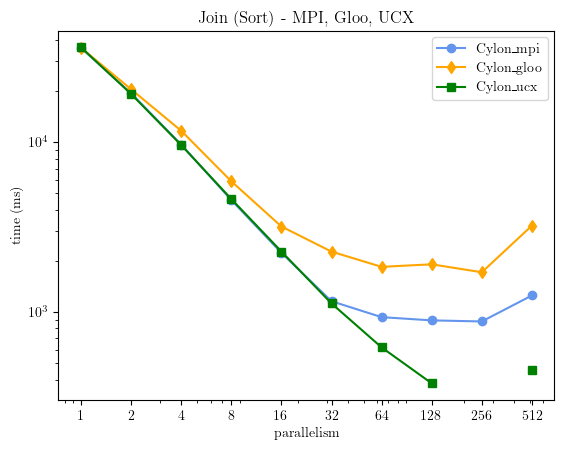

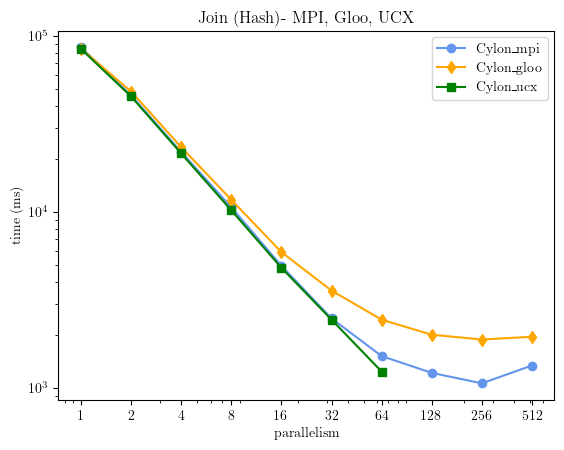

,world,Cylon_mpi,Cylon_gloo,Cylon_ucx
0,1,86508.634197,84981.550217,84661.860069
1,2,46067.080366,48467.083494,45446.671287
2,4,21965.075129,23373.314699,21535.531620
3,8,10637.190806,11742.036194,10228.867481
4,16,4938.266269,5910.055896,4814.764614
5,32,2482.377859,3572.714731,2441.049653
6,64,1514.591127,2441.024496,1236.814465
7,128,1215.547123,2004.011941,NaN
8,256,1059.867303,1881.550698,NaN
9,512,1338.252703,1950.100145,NaN


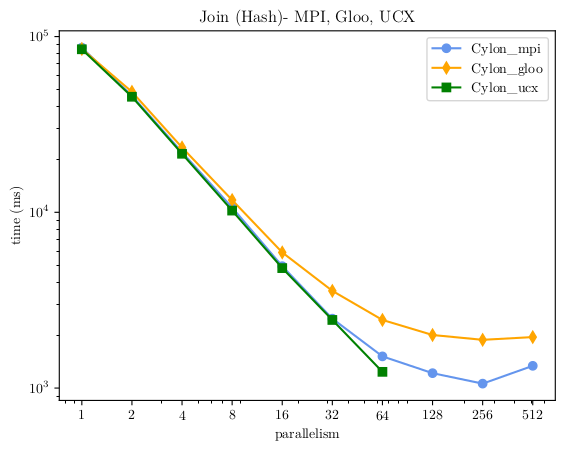

In [102]:
process_join_comms(f'{data_dir}/join.csv', 'Join (Sort) - MPI, Gloo, UCX',
                   f'{resultsgraphs}/cylon_join_comms_100M.pgf', 100000000)
process_join_comms(f'{data_dir}/join.csv', 'Join (Hash)- MPI, Gloo, UCX',
                   f'{resultsgraphs}/cylon_join_comms_100M_hash.pgf', 100000000, algo='hash')

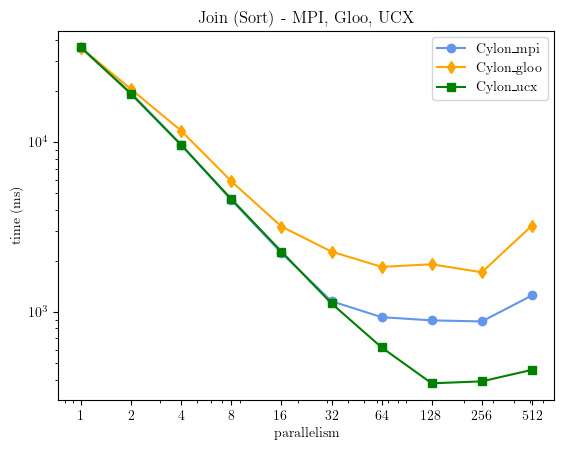

,world,Cylon_mpi,Cylon_gloo,Cylon_ucx
0,1,35955.641508,36066.167275,36297.522783
1,2,19470.111797,20535.562952,19265.097578
2,4,9695.878034,11694.131454,9633.302748
3,8,4567.248677,5892.522514,4631.492635
4,16,2229.684319,3190.356071,2271.107609
5,32,1157.323117,2268.358561,1122.731877
6,64,932.404771,1845.201865,618.410390
7,128,892.309846,1909.851696,379.805378
8,256,879.494205,1714.529375,390.077398
9,512,1251.473340,3228.655145,455.940791


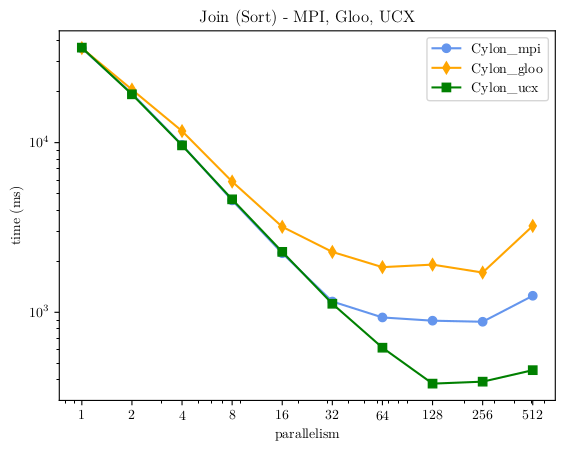

In [5]:
process_join_comms(f'{data_dir}/join.csv', 'Join (Sort) - MPI, Gloo, UCX',
                   f'{resultsgraphs}/cylon_join_comms_100M.pgf', 100000000)

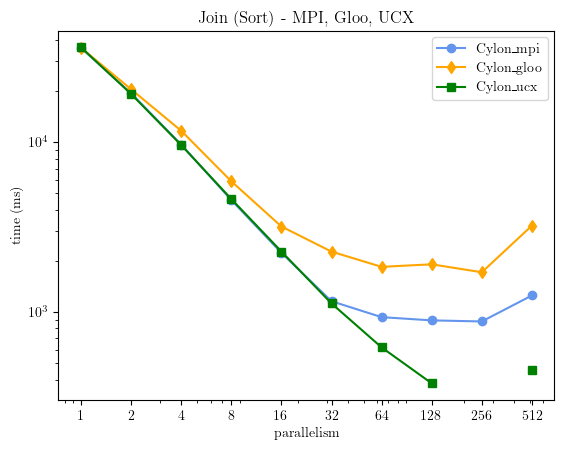

,world,Cylon_mpi,Cylon_gloo,Cylon_ucx
0,1,35955.641508,36066.167275,36297.522783
1,2,19470.111797,20535.562952,19265.097578
2,4,9695.878034,11694.131454,9633.302748
3,8,4567.248677,5892.522514,4631.492635
4,16,2229.684319,3190.356071,2271.107609
5,32,1157.323117,2268.358561,1122.731877
6,64,932.404771,1845.201865,618.410390
7,128,892.309846,1909.851696,379.805378
8,256,879.494205,1714.529375,NaN
9,512,1251.473340,3228.655145,455.940791


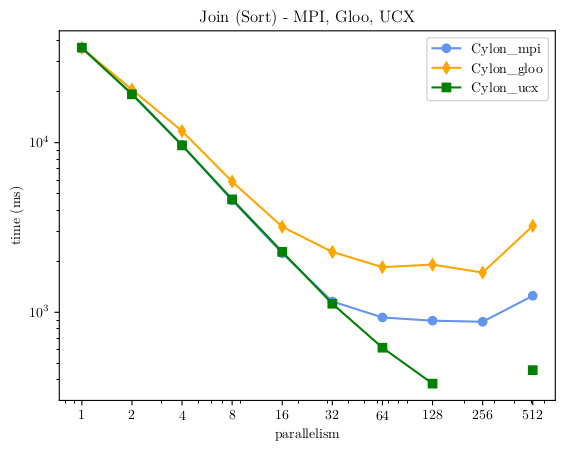

In [4]:
process_join_comms(f'{data_dir}/join.csv', 'Join (Sort) - MPI, Gloo, UCX',
                   f'{resultsgraphs}/cylon_join_comms_100M.pgf', 100000000)

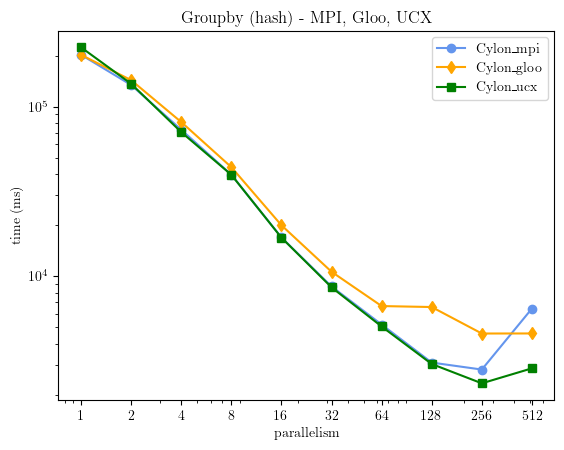

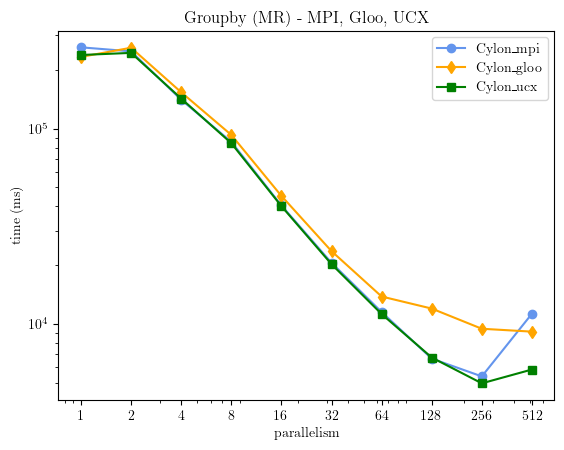

,world,Cylon_mpi,Cylon_gloo,Cylon_ucx
0,1,260672.506843,232803.843419,238172.683795
1,2,248568.720545,259427.553654,244137.731234
2,4,140490.461988,153476.005971,142509.250820
3,8,85592.544360,92855.753283,84231.785675
4,16,40436.527391,45250.692045,40112.665221
5,32,20573.009912,23602.911097,20246.545918
6,64,11521.265810,13830.050237,11250.130941
7,128,6654.251071,11997.109752,6740.317168
8,256,5394.329346,9458.169711,4972.330791
9,512,11290.019295,9142.402314,5850.408539


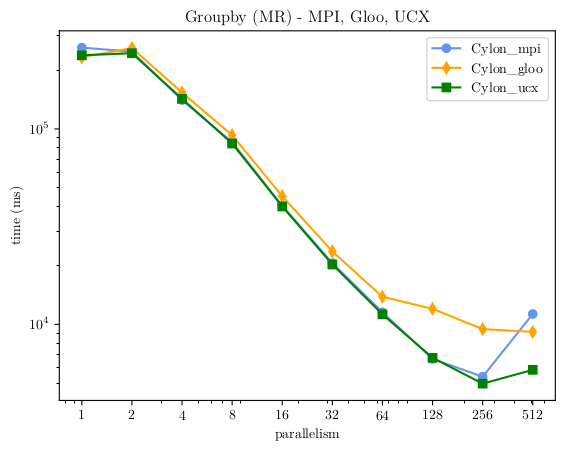

In [105]:
def process_groupby_comms(cy, title, out_file, rows, tag_match, just_show=False):
    cylon_df = pd.read_csv(cy, comment='#')
    # modin_df = pd.read_csv(mod, comment='#')
    # dask_df = pd.read_csv(dask, comment='#')

    # cylon_hash_avg = sqldf(
    #     f"SELECT world, avg(time) as avg FROM cylon_df WHERE rows={rows} AND tag like '%hash%' GROUP BY world", locals())
    cylon_sort_avg_mpi = sqldf(
        f"SELECT world, avg(time) as avg FROM cylon_df WHERE rows={rows} AND tag like '%{tag_match}%c=mpi' AND it!=0 GROUP BY world",
        locals())
    cylon_sort_avg_gloo = sqldf(
        f"SELECT world, avg(time) as avg FROM cylon_df WHERE rows={rows} AND tag like '%{tag_match}%c=gloo' AND it!=0 GROUP BY world",
        locals())
    cylon_sort_avg_ucx = sqldf(
        f"SELECT world, avg(time) as avg FROM cylon_df WHERE rows={rows} AND tag like '%{tag_match}%c=ucx' AND it!=0 GROUP BY world",
        locals())

    data = sqldf(
        f"""SELECT cym.world, cym.avg AS {cylon}_mpi, cyg.avg as {cylon}_gloo, cyu.avg AS {cylon}_ucx
          FROM cylon_sort_avg_mpi cym
          JOIN cylon_sort_avg_gloo cyg ON cym.world = cyg.world
          JOIN cylon_sort_avg_ucx cyu ON cym.world = cyu.world
          """, locals())
    
    colors_ = {f'{cylon}_mpi': 'cornflowerblue', f'{cylon}_gloo': 'orange', f'{cylon}_ucx': 'green'}
    plot(data, out_file, title, True, colors=colors_)
    plot(data, out_file, title, False, colors=colors_)
    
    return data

process_groupby_comms(f'{data_dir}/groupby.csv', 'Groupby (hash) - MPI, Gloo, UCX',
                   f'{resultsgraphs}/cylon_gby_hash_comms.pgf', 1000000000, 'a=hash%u=0.9',None)
process_groupby_comms(f'{data_dir}/groupby.csv', 'Groupby (MR) - MPI, Gloo, UCX',
                   f'{resultsgraphs}/cylon_gby_mr_comms.pgf', 1000000000, 'a=mapred_hash%u=0.9',None)


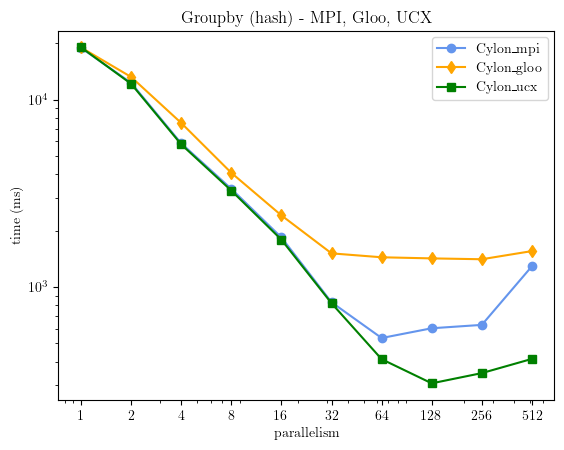

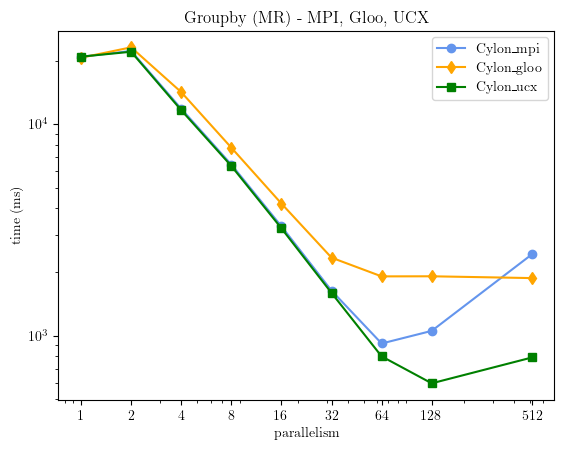

,world,Cylon_mpi,Cylon_gloo,Cylon_ucx
0,1,20861.967421,20652.295589,20898.009968
1,2,22232.146668,23134.586501,22049.348760
2,4,11853.328156,14203.857982,11671.849573
3,8,6456.132263,7759.926409,6357.152903
4,16,3293.892977,4221.797782,3224.645954
5,32,1635.203409,2341.811159,1595.204727
6,64,919.651081,1909.891422,799.366947
7,128,1055.175440,1911.914293,596.040696
8,512,2428.211059,1874.716711,789.667200


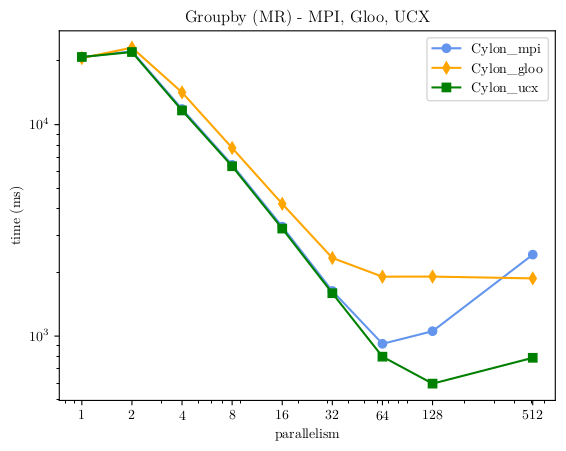

In [110]:
process_groupby_comms(f'{data_dir}/groupby.csv', 'Groupby (hash) - MPI, Gloo, UCX',
                   f'{resultsgraphs}/cylon_gby_hash_comms_100M.pgf', 100000000, 'a=hash%u=0.9',None)
process_groupby_comms(f'{data_dir}/groupby.csv', 'Groupby (MR) - MPI, Gloo, UCX',
                   f'{resultsgraphs}/cylon_gby_mr_comms_100M.pgf', 100000000, 'a=mapred_hash%u=0.9',None)

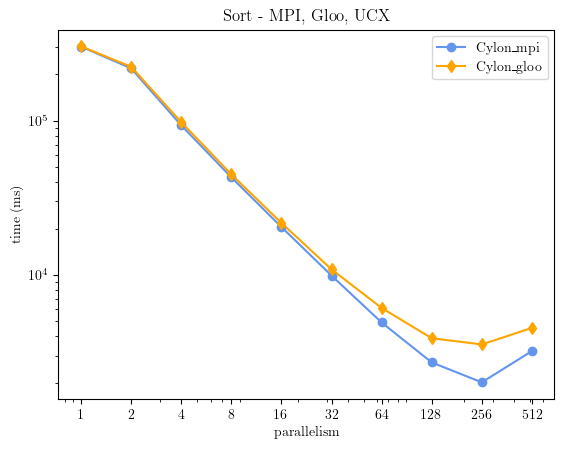

,world,Cylon_mpi,Cylon_gloo
0,1,302151.194572,303415.500641
1,2,218474.884351,223674.504360
2,4,93354.044298,97927.002430
3,8,42976.905197,44905.778925
4,16,20473.858600,21744.979893
5,32,9912.570136,10887.486922
6,64,4923.994444,6117.146943
7,128,2713.072496,3894.464890
8,256,2016.478711,3548.630017
9,512,3213.600735,4543.361607


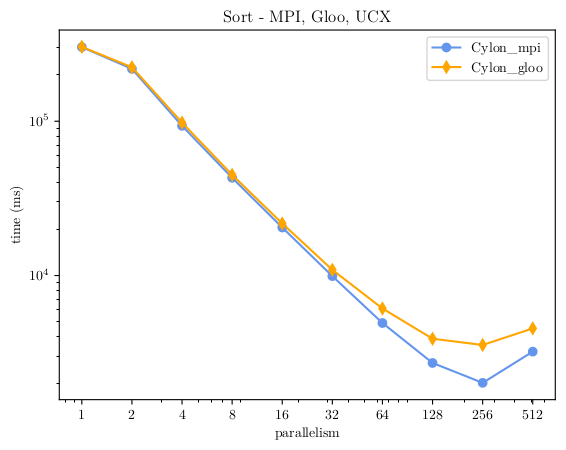

In [65]:
def process_sort_comms(cy, title, out_file, rows, tag_match, just_show=False):
    cylon_df = pd.read_csv(cy, comment='#')

    cylon_sort_avg_mpi = sqldf(
        f"SELECT world, avg(time) as avg FROM cylon_df WHERE rows={rows} AND tag like '%{tag_match}%c=mpi' AND it!=0 GROUP BY world",
        locals())
    cylon_sort_avg_gloo = sqldf(
        f"SELECT world, avg(time) as avg FROM cylon_df WHERE rows={rows} AND tag like '%{tag_match}%c=gloo' AND it!=0 GROUP BY world",
        locals())

    data = sqldf(
        f"""SELECT cym.world, cym.avg AS {cylon}_mpi, cyg.avg as {cylon}_gloo
          FROM cylon_sort_avg_mpi cym
          JOIN cylon_sort_avg_gloo cyg ON cym.world = cyg.world
          """, locals())
    
    colors_ = {f'{cylon}_mpi': 'cornflowerblue', f'{cylon}_gloo': 'orange', f'{cylon}_ucx': 'green'}
    plot(data, out_file, title, True, colors=colors_)
    plot(data, out_file, title, False, colors=colors_)
    
    return data

process_sort_comms(f'{data_dir}/sort.csv', 'Sort - MPI, Gloo, UCX',
                   f'{resultsgraphs}/cylon_sort_comms.pgf', 1000000000, 'a=initial',None)

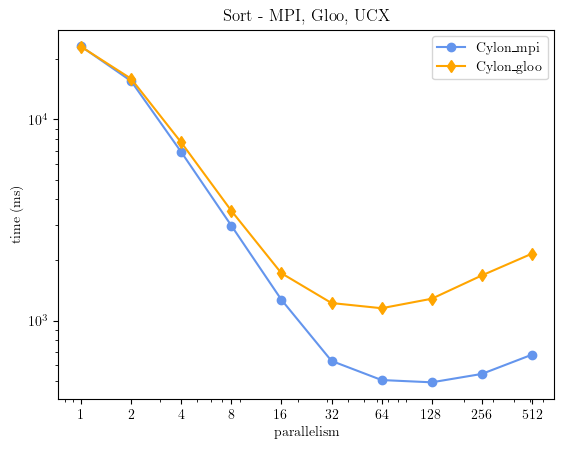

,world,Cylon_mpi,Cylon_gloo
0,1,23105.733395,23017.647076
1,2,15523.763967,15939.948595
2,4,6889.577866,7684.984207
3,8,2966.657847,3516.705224
4,16,1269.064626,1719.175623
5,32,629.964459,1222.194955
6,64,506.033248,1151.606899
7,128,492.973634,1283.793258
8,256,542.681311,1676.160072
9,512,676.397879,2150.480230


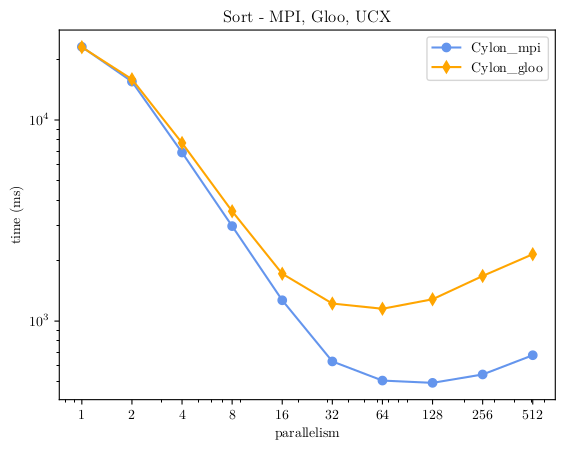

In [114]:
process_sort_comms(f'{data_dir}/sort.csv', 'Sort - MPI, Gloo, UCX',
                   f'{resultsgraphs}/cylon_sort_comms_100M.pgf', 100000000, 'a=initial',None)

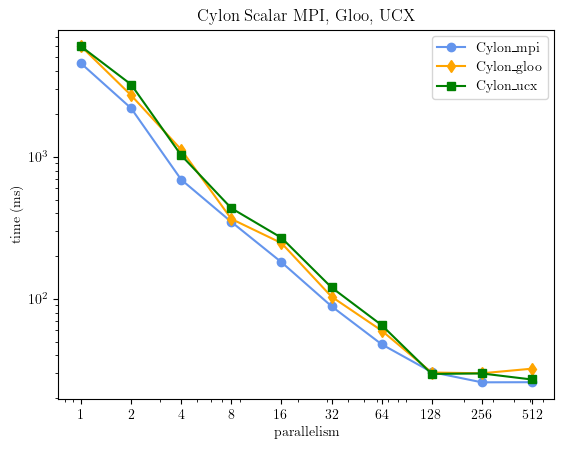

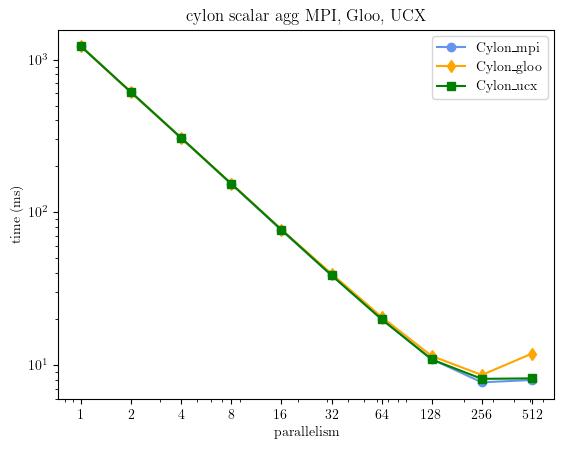

,world,Cylon_mpi,Cylon_gloo,Cylon_ucx
0,1,1221.198559,1221.428951,1219.803333
1,2,608.973940,609.906157,610.920191
2,4,305.960596,306.661884,306.893905
3,8,153.068423,153.801372,153.697183
4,16,76.272060,77.112138,76.891462
5,32,38.741348,39.624934,38.680544
6,64,19.912666,20.627420,19.947641
7,128,10.909849,11.445640,10.862838
8,256,7.697381,8.599305,8.111628
9,512,7.971556,11.866500,8.170191


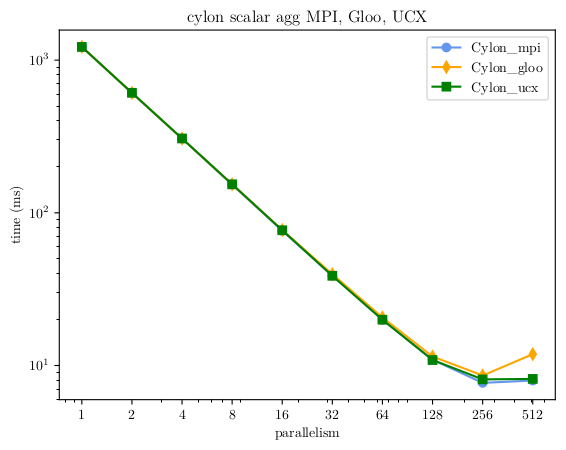

In [67]:
def process_scalar_comms(cy, title, out_file, rows, just_show=False):
    cylon_df = pd.read_csv(cy, comment='#')
    # modin_df = pd.read_csv(mod, comment='#')
    # dask_df = pd.read_csv(dask, comment='#')

    # cylon_hash_avg = sqldf(
    #     f"SELECT world, avg(time) as avg FROM cylon_df WHERE rows={rows} AND tag like '%hash%' GROUP BY world", locals())
    cylon_sort_avg_mpi = sqldf(
        f"SELECT world, avg(time) as avg FROM cylon_df WHERE rows={rows} AND tag like '%c=mpi%' AND it!=0 GROUP BY world",
        locals())
    cylon_sort_avg_gloo = sqldf(
        f"SELECT world, avg(time) as avg FROM cylon_df WHERE rows={rows} AND tag like '%c=gloo%' AND it!=0 GROUP BY world",
        locals())
    cylon_sort_avg_ucx = sqldf(
        f"SELECT world, avg(time) as avg FROM cylon_df WHERE rows={rows} AND tag like '%c=ucx%' AND it!=0 GROUP BY world",
        locals())

    data = sqldf(
        f"""SELECT cym.world, cym.avg AS {cylon}_mpi, cyg.avg as {cylon}_gloo, cyu.avg AS {cylon}_ucx
          FROM cylon_sort_avg_mpi cym
          JOIN cylon_sort_avg_gloo cyg ON cym.world = cyg.world
          JOIN cylon_sort_avg_ucx cyu ON cym.world = cyu.world
          """, locals())

    plot(data, out_file, title, True,
         colors={f'{cylon}_mpi': 'cornflowerblue', f'{cylon}_gloo': 'orange',
                 f'{cylon}_ucx': 'green'})
    plot(data, out_file, title, False,
         colors={f'{cylon}_mpi': 'cornflowerblue', f'{cylon}_gloo': 'orange',
                 f'{cylon}_ucx': 'green'})
    
    return data

process_scalar_comms(f'{data_dir}/scalar.csv', f'{cylon} Scalar MPI, Gloo, UCX',
                   f'{resultsgraphs}/cylon_scalar_comms.pgf', 1000000000, just_show)
process_scalar_comms(f'{data_dir}/scalar-agg.csv', 'cylon scalar agg MPI, Gloo, UCX',
                   f'{resultsgraphs}/cylon_scalar_agg_comms.pgf', 1000000000, just_show)

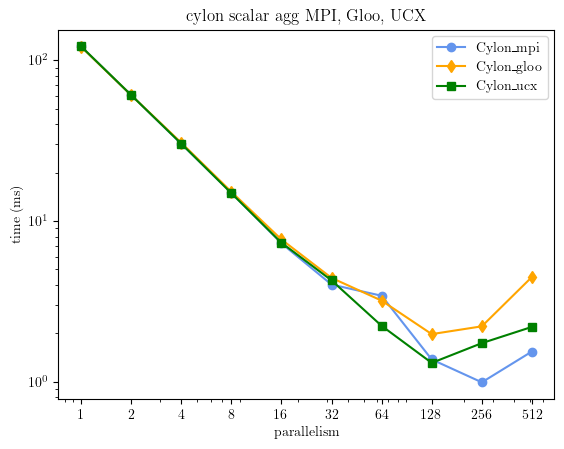

,world,Cylon_mpi,Cylon_gloo,Cylon_ucx
0,1,121.998549,121.576357,122.256613
1,2,60.860538,60.785842,60.836029
2,4,30.261624,30.723143,30.326426
3,8,14.961660,15.214741,14.915794
4,16,7.265216,7.676244,7.327276
5,32,4.022661,4.425618,4.272848
6,64,3.426649,3.196269,2.226371
7,128,1.375274,1.977491,1.309288
8,256,0.991006,2.210960,1.737525
9,512,1.541386,4.484591,2.192834


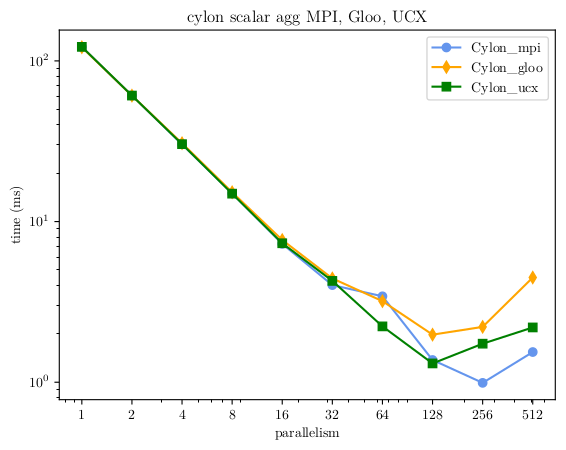

In [112]:
process_scalar_comms(f'{data_dir}/scalar-agg.csv', 'cylon scalar agg MPI, Gloo, UCX',
                   f'{resultsgraphs}/cylon_scalar_agg_comms_100M.pgf', 100000000, just_show)

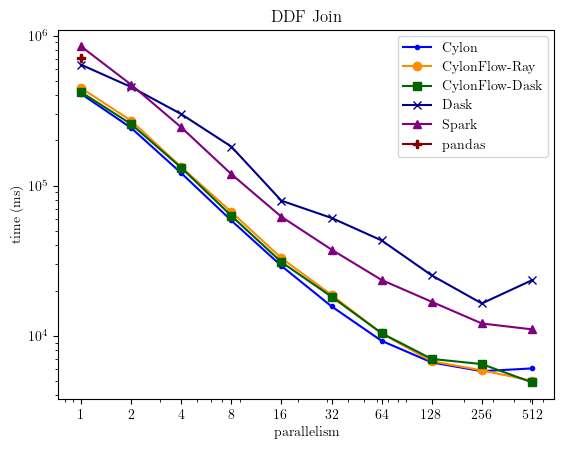

,world,Cylon,CylonFlow-Ray,CylonFlow-Dask,Dask,Spark,pandas
0,1,409185.396115,446907.695312,420200.424107,639354.469633,847201.018201,705125.56994
1,2,242424.797336,271047.273438,256931.073661,453845.482397,470407.287783,NaN
2,4,121240.434905,132961.445312,131779.355469,299640.709698,244510.379394,NaN
3,8,58566.811552,66808.412109,62969.057617,181818.096352,119308.051851,NaN
4,16,29187.274352,32868.520996,30927.463379,79360.196066,61998.463601,NaN
5,32,15686.577188,18707.454799,18204.160156,60906.038046,37469.982439,NaN
6,64,9242.033334,10345.832450,10389.881836,43124.872589,23506.499979,NaN
7,128,6640.439497,6761.296177,7002.274780,25231.248903,16829.565346,NaN
8,256,5803.891781,5875.820801,6470.640462,16408.410597,12065.257788,NaN
9,512,6053.764271,5013.351318,4891.380697,23420.881081,11024.170187,NaN


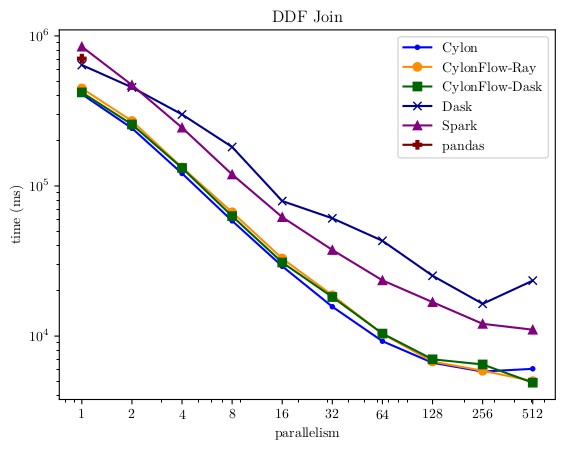

In [89]:
# def process_join_comms(cy, mod, dask, pandas_, title, out_file, rows, just_show=False):
def cflow_join(title, out_file, rows, just_show=False):
    op = 'join'
    cdf = pd.read_csv(f'{data_dir}/{op}.csv', comment='#')
    cflowray = pd.read_csv(f'{data_dir}/cylon_ray_{op}.csv', comment='#')
    cflowdask = pd.read_csv(f'{data_dir}/cylon_dask_{op}.csv', comment='#')
    dask = pd.read_csv(f'{data_dir}/dask_{op}.csv', comment='#')
    spark = pd.read_csv(f'{data_dir}/spark_{op}.csv', comment='#')

    df0 = sqldf(
        f"SELECT world, avg(time) as avg FROM cdf WHERE rows={rows} AND tag like '%a=sort u=0.9 c=gloo%' AND it!=0 GROUP BY world ORDER BY world", locals())
    df1 = sqldf(
        f"SELECT world, avg(time) as avg FROM cflowray WHERE rows={rows} AND tag like '%a=sort u=0.9 c=gloo%' AND it!=0 GROUP BY world ORDER BY world", locals())
    df2 = sqldf(
        f"SELECT world, avg(time) as avg FROM cflowdask WHERE rows={rows} AND tag like '%a=sort u=0.9 c=gloo%' AND it!=0 GROUP BY world ORDER BY world", locals())
    df3 = sqldf(
        f"SELECT world, avg(time) as avg FROM dask WHERE rows={rows} AND it!=0 GROUP BY world ORDER BY world", locals())
    df4 = sqldf(
        f"SELECT world, avg(time) as avg FROM spark WHERE rows={rows} AND it!=0 GROUP BY world ORDER BY world", locals())
    
    # print(cylon_df[cylon_df['world'] == 512])
    # print(dask_df[dask_df['world'] == 512])
    # print(df3)
    
    data=pd.concat([df0, df1['avg'], df2['avg'], df3['avg'], df4['avg']], axis=1)
    data.columns=['world', cylon, f'{cflow}-Ray', f'{cflow}-Dask', 'Dask', 'Spark']
    
    # data = sqldf(f"""SELECT cy.world, cy.avg AS {cylon}, md.avg AS ray, da.avg as dask
    #   FROM df0 cy
    #   JOIN df1 md ON cy.world = md.world
    #   JOIN df2 da ON da.world = cy.world
    #   """, locals())


    pd_df = pd.read_csv(f'{data_dir}/pandas_join.csv', comment='#')
    pd_avg = sqldf(
        f"SELECT world, avg(time) as avg FROM pd_df WHERE rows={rows} GROUP BY world", locals())
    l = [None for _ in range(len(data))]
    l[0] = pd_avg['avg'][0]
    data['pandas'] = l
    
    plot(data, out_file, title, True, colors=colors)
    
    plot(data, out_file, title, False, colors=colors)
    
    return data


cflow_join(f'DDF Join', f'{resultsgraphs}/cflow_join.pgf', 1000000000, just_show=None)

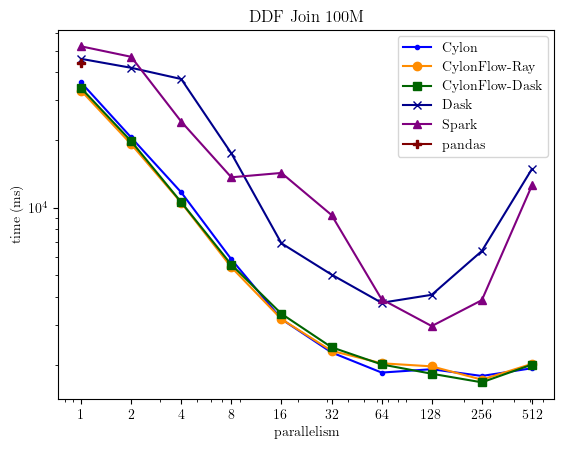

,world,Cylon,CylonFlow-Ray,CylonFlow-Dask,Dask,Spark,pandas
0,1,36066.167275,33166.918750,34055.216406,45914.642215,52198.020577,43807.772636
1,2,20535.562952,19167.652344,19754.905078,41901.000321,46890.456498,NaN
2,4,11694.131454,10519.021875,10572.183008,37341.491878,24152.607799,NaN
3,8,5892.522514,5430.783789,5576.651074,17445.756674,13643.049479,NaN
4,16,3190.356071,3190.655273,3369.466846,6938.918209,14266.823649,NaN
5,32,2268.358561,2306.548779,2391.837109,5035.581732,9272.806406,NaN
6,64,1845.201865,2029.607935,2005.833105,3772.268438,3910.159051,NaN
7,128,1909.851696,1966.331226,1823.506909,4093.422270,2970.829129,NaN
8,256,1782.246425,1716.309058,1669.792139,6409.523249,3873.622835,NaN
9,512,1928.736932,2018.097809,2002.556366,14857.713652,12548.650384,NaN


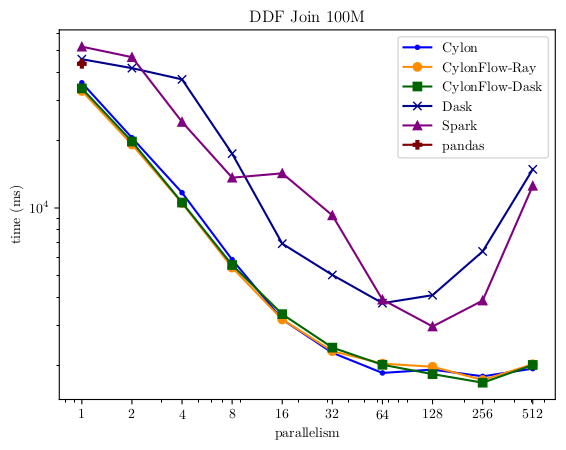

In [94]:
cflow_join(f'DDF Join 100M', f'{resultsgraphs}/cflow_join_100m.pgf', 100000000, just_show=None)

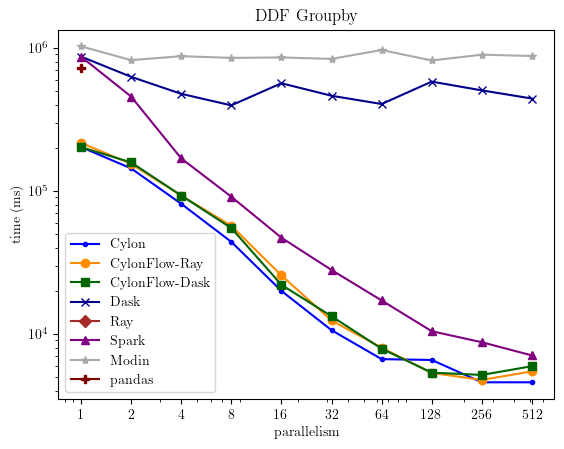

,world,Cylon,CylonFlow-Ray,CylonFlow-Dask,Dask,Ray,Spark,Modin,pandas
0,1,202413.766623,216573.386161,202265.962054,867792.817146,NaN,867187.831211,1.023628e+06,726710.740507
1,2,143527.668079,154346.535714,158004.870536,626467.576057,NaN,455875.105572,8.194281e+05,NaN
2,4,81217.897117,92615.484375,92777.981027,476520.910025,NaN,168586.329365,8.734361e+05,NaN
3,8,44011.412352,56983.054688,54934.541295,395927.389145,NaN,90965.979457,8.496670e+05,NaN
4,16,19982.865577,25647.076451,22033.678013,565002.696991,NaN,47047.025585,8.558352e+05,NaN
5,32,10620.938356,12410.152762,13292.453683,461991.052945,NaN,27981.979084,8.359693e+05,NaN
6,64,6662.978447,8007.343401,7885.526995,404526.781480,NaN,17134.374797,9.646933e+05,NaN
7,128,6575.643279,5336.921456,5359.902134,580021.078587,NaN,10443.365991,8.148371e+05,NaN
8,256,4588.388373,4768.018834,5168.916016,503697.638512,NaN,8746.273756,8.947955e+05,NaN
9,512,4591.815310,5472.799927,5948.860514,441801.900387,NaN,7073.992395,8.759372e+05,NaN


In [90]:
# def process_join_comms(cy, mod, dask, pandas_, title, out_file, rows, just_show=False):
def cflow_groupby(title, out_file, rows, just_show=False):
    op = 'groupby'
    cylon_df = pd.read_csv(f'{data_dir}/{op}.csv', comment='#')
    cflowray = pd.read_csv(f'{data_dir}/cylon_ray_{op}.csv', comment='#')
    cflowdask = pd.read_csv(f'{data_dir}/cylon_dask_{op}.csv', comment='#')
    dask = pd.read_csv(f'{data_dir}/dask_{op}.csv', comment='#')
    ray = pd.read_csv(f'{data_dir}/ray_{op}.csv', comment='#')
    spark = pd.read_csv(f'{data_dir}/spark_{op}.csv', comment='#')
    modin = pd.read_csv(f'{data_dir}/modin_{op}.csv', comment='#')

    algo = 'hash'
    df0 = sqldf(
        f"SELECT world, avg(time) as avg FROM cylon_df WHERE rows={rows} AND tag like '%a={algo}%c=gloo%' AND it!=0 GROUP BY world ORDER BY world", locals())
    df1 = sqldf(
        f"SELECT world, avg(time) as avg FROM cflowray WHERE rows={rows} AND tag like '%a={algo}%c=gloo%' AND it!=0 GROUP BY world ORDER BY world", locals())
    df2 = sqldf(
        f"SELECT world, avg(time) as avg FROM cflowdask WHERE rows={rows} AND tag like '%a={algo}%c=gloo%' AND it!=0 GROUP BY world ORDER BY world", locals())
    df3 = sqldf(
        f"SELECT world, avg(time) as avg FROM dask WHERE rows={rows} AND it!=0 GROUP BY world ORDER BY world", locals())
    df4 = sqldf(
        f"SELECT world, avg(time) as avg FROM ray WHERE rows={rows} AND it!=0 GROUP BY world ORDER BY world", locals())
    df5 = sqldf(
        f"SELECT world, avg(time) as avg FROM spark WHERE rows={rows} AND it!=0 GROUP BY world ORDER BY world", locals())    
    df6 = sqldf(
        f"SELECT world, avg(time) as avg FROM modin WHERE rows={rows} GROUP BY world ORDER BY world", locals()) 
    
    data=pd.concat([df0, df1['avg'], df2['avg'], df3['avg'], df4['avg'], df5['avg'], df6['avg']], axis=1)
    data.columns=['world', cylon, f'{cflow}-Ray', f'{cflow}-Dask', 'Dask', 'Ray', 'Spark', 'Modin']
    
    # data = sqldf(f"""SELECT cy.world, cy.avg AS {cylon}, md.avg AS ray, da.avg as dask
    #   FROM df0 cy
    #   JOIN df1 md ON cy.world = md.world
    #   JOIN df2 da ON da.world = cy.world
    #   """, locals())


    pd_df = pd.read_csv(f'{data_dir}/pandas_{op}.csv', comment='#')
    pd_avg = sqldf(
        f"SELECT world, avg(time) as avg FROM pd_df WHERE rows={rows} GROUP BY world", locals())
    if len(pd_avg):
        l = [None for _ in range(len(data))]
        l[0] = pd_avg['avg'][0]
        data['pandas'] = l
    
    # print(data)
    plot(data, out_file, title, False, colors=colors)
    plot(data, out_file, title, True, colors=colors)
    
    return data


cflow_groupby(f'DDF Groupby', f'{resultsgraphs}/cflow_groupby.pgf', 1000000000, None)

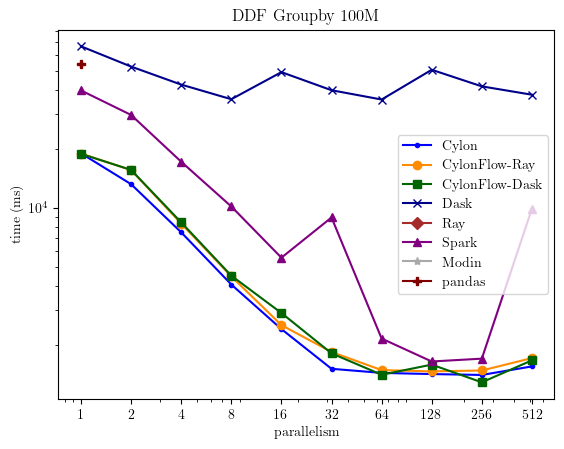

,world,Cylon,CylonFlow-Ray,CylonFlow-Dask,Dask,Ray,Spark,Modin,pandas
0,1,18983.565784,18934.362500,18872.459766,66701.060057,NaN,39733.199239,NaN,54285.135031
1,2,13209.834397,15587.952148,15619.475000,52576.230192,NaN,29785.983205,NaN,NaN
2,4,7506.491107,8320.413574,8435.029102,42551.302195,NaN,17194.910824,NaN,NaN
3,8,4066.403556,4472.377344,4512.065430,35835.504341,NaN,10168.967843,NaN,NaN
4,16,2410.314871,2524.860596,2910.416260,49259.868145,NaN,5572.981596,NaN,NaN
5,32,1511.548451,1841.924658,1812.797144,39830.006838,NaN,8935.988784,NaN,NaN
6,64,1440.546361,1488.700513,1409.445166,35705.991459,NaN,2155.990958,NaN,NaN
7,128,1420.921656,1466.567603,1587.353052,50639.405298,NaN,1647.225499,NaN,NaN
8,256,1406.152799,1481.680298,1289.581146,41677.605343,NaN,1702.694178,NaN,NaN
9,512,1554.417859,1714.348236,1669.477376,37781.612968,NaN,9905.106624,NaN,NaN


In [91]:
cflow_groupby(f'DDF Groupby 100M', f'{resultsgraphs}/cflow_groupby_100m.pgf', 100000000, None)

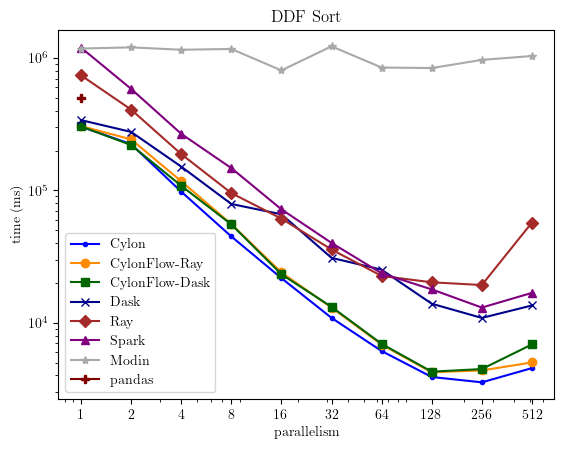

,world,Cylon,CylonFlow-Ray,CylonFlow-Dask,Dask,Ray,Spark,Modin,pandas
0,1,303415.500641,306383.393750,304826.541667,339864.141434,740733.329415,1.199813e+06,1.180877e+06,501213.823318
1,2,223674.504360,243102.612500,220306.364583,276807.482302,408242.626429,5.850891e+05,1.205229e+06,NaN
2,4,97927.002430,117351.032812,108499.690104,151344.714483,188181.328297,2.677619e+05,1.156413e+06,NaN
3,8,44905.778925,55679.090625,55378.819010,78995.740334,95508.385777,1.475174e+05,1.172123e+06,NaN
4,16,21744.979893,23988.629297,23258.057292,66045.089483,61226.263762,7.197626e+04,8.073391e+05,NaN
5,32,10887.486922,13027.449609,13191.464844,30947.041829,35787.846506,4.012560e+04,1.227272e+06,NaN
6,64,6117.146943,6839.819824,6931.699870,25181.685527,22581.687510,2.363447e+04,8.486811e+05,NaN
7,128,3894.464890,4225.886230,4271.271647,13932.737112,20220.849037,1.787848e+04,8.407687e+05,NaN
8,256,3548.630017,4363.639941,4469.377197,10879.658381,19286.217570,1.303157e+04,9.690745e+05,NaN
9,512,4543.361607,5015.460632,6861.365885,13513.130665,57158.953309,1.682320e+04,1.036781e+06,NaN


In [92]:
def cflow_sort(title, out_file, rows, just_show=False):
    op='sort'
    cylon_df = pd.read_csv(f'{data_dir}/{op}.csv', comment='#')
    cflowdray = pd.read_csv(f'{data_dir}/cylon_ray_{op}.csv', comment='#')
    cflowdask = pd.read_csv(f'{data_dir}/cylon_dask_{op}.csv', comment='#')
    dask = pd.read_csv(f'{data_dir}/dask_{op}.csv', comment='#')
    ray = pd.read_csv(f'{data_dir}/ray_{op}.csv', comment='#')
    spark = pd.read_csv(f'{data_dir}/spark_{op}.csv', comment='#')
    modin = pd.read_csv(f'{data_dir}/modin_{op}.csv', comment='#')

    algo = 'initial'
    df0 = sqldf(
        f"SELECT world, avg(time) as avg FROM cylon_df WHERE rows={rows} AND tag like '%a={algo}%c=gloo%' AND it!=0 GROUP BY world", locals())
    df1 = sqldf(
        f"SELECT world, avg(time) as avg FROM cflowdray WHERE rows={rows} AND tag like '%a={algo}%c=gloo%' AND it!=0 GROUP BY world", locals())
    df2 = sqldf(
        f"SELECT world, avg(time) as avg FROM cflowdask WHERE rows={rows} AND tag like '%a={algo}%c=gloo%' AND it!=0 GROUP BY world", locals())
    df3 = sqldf(
        f"SELECT world, avg(time) as avg FROM dask WHERE rows={rows} AND it!=0 GROUP BY world ORDER BY world", locals())
    df4 = sqldf(
        f"SELECT world, avg(time) as avg FROM ray WHERE rows={rows} AND it!=0 GROUP BY world ORDER BY world", locals())
    df5 = sqldf(
        f"SELECT world, avg(time) as avg FROM spark WHERE rows={rows} AND it!=0 GROUP BY world ORDER BY world", locals())  
    df6 = sqldf(
        f"SELECT world, avg(time) as avg FROM modin WHERE rows={rows} GROUP BY world ORDER BY world", locals()) 
    
    # print(cylon_df[cylon_df['world'] == 512])
    # print(dask_df[dask_df['world'] == 512])

    
    data=pd.concat([df0, df1['avg'], df2['avg'], df3['avg'], df4['avg'], df5['avg'], df6['avg']], axis=1)
    data.columns=['world', cylon, f'{cflow}-Ray', f'{cflow}-Dask', 'Dask', 'Ray', 'Spark', 'Modin']
    # data = sqldf(f"""SELECT cy.world, cy.avg AS {cylon}, md.avg AS ray, da.avg as dask
    #   FROM df0 cy
    #   JOIN df1 md ON cy.world = md.world
    #   JOIN df2 da ON da.world = cy.world
    #   """, locals())


    pd_df = pd.read_csv(f'{data_dir}/pandas_{op}.csv', comment='#')
    pd_avg = sqldf(
        f"SELECT world, avg(time) as avg FROM pd_df WHERE rows={rows} GROUP BY world", locals())
    l = [None for _ in range(len(data))]
    if len(pd_avg):
        l[0] = pd_avg['avg'][0] 
    data['pandas'] = l

    plot(data, out_file, title, False, colors=colors)
    plot(data, out_file, title, True, colors=colors)
        
    return data


cflow_sort('DDF Sort', f'{resultsgraphs}/cflow_sort.pgf', 1000000000, None)

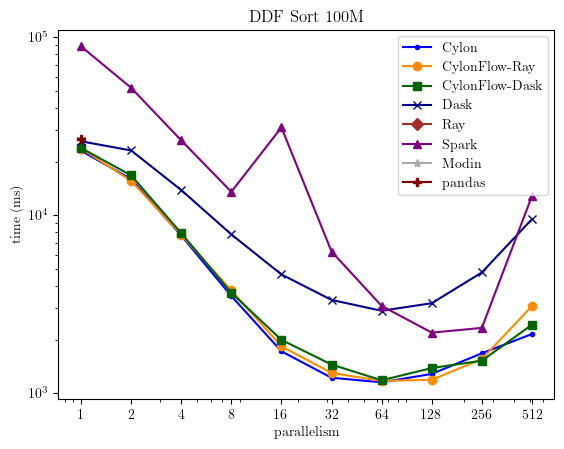

,world,Cylon,CylonFlow-Ray,CylonFlow-Dask,Dask,Ray,Spark,Modin,pandas
0,1,23017.647076,23682.160156,23836.616797,25994.086313,NaN,88773.207235,NaN,26680.957127
1,2,15939.948595,15603.827539,16733.556055,23089.876986,NaN,51896.457148,NaN,NaN
2,4,7684.984207,7760.207324,7926.285742,13839.812851,NaN,26302.621794,NaN,NaN
3,8,3516.705224,3780.315088,3666.671582,7797.478151,NaN,13525.342226,NaN,NaN
4,16,1719.175623,1835.364990,1994.227271,4648.354483,NaN,31105.004501,NaN,NaN
5,32,1222.194955,1300.474463,1449.278125,3341.465902,NaN,6249.524307,NaN,NaN
6,64,1151.606899,1172.831421,1182.372559,2904.659653,NaN,3093.390179,NaN,NaN
7,128,1283.793258,1190.643848,1385.353003,3202.769756,NaN,2189.686108,NaN,NaN
8,256,1676.160072,1554.028418,1523.097437,4766.448689,NaN,2327.567387,NaN,NaN
9,512,2150.480230,3086.599023,2423.127295,9498.931551,NaN,12792.009294,NaN,NaN


In [93]:
cflow_sort('DDF Sort 100M', f'{resultsgraphs}/cflow_sort_100m.pgf', 100000000, None)

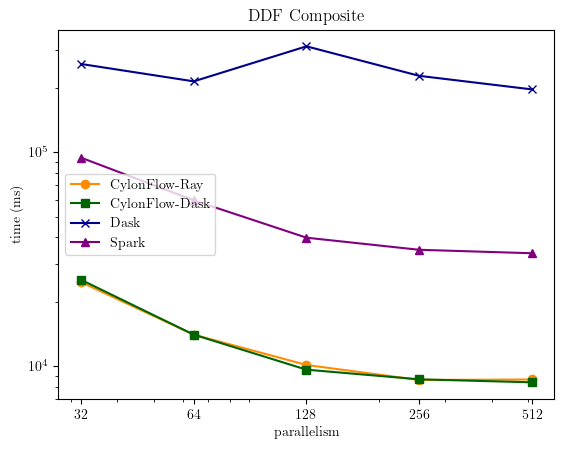

,world,CylonFlow-Ray,CylonFlow-Dask,Dask,Spark
0,32,24665.348958,25299.777344,258472.447236,94234.099785
1,64,14014.297852,14009.652018,214369.780858,59516.188860
2,128,10105.987630,9608.307943,312604.471604,39808.725357
3,256,8599.040365,8660.660156,227462.364038,34944.661697
4,512,8644.631185,8384.926758,196586.897532,33667.332013


In [255]:
def cflow_composite(title, out_file, rows, just_show=False):
    op='composite'
    cflowdray = pd.read_csv(f'{data_dir}/cylon_ray_{op}.csv', comment='#')
    cflowdask = pd.read_csv(f'{data_dir}/cylon_dask_{op}.csv', comment='#')
    dask = pd.read_csv(f'{data_dir}/dask_{op}.csv', comment='#')
    spark = pd.read_csv(f'{data_dir}/spark_{op}.csv', comment='#')

    df0 = sqldf(
        f"SELECT world, avg(time) as avg FROM cflowdray WHERE rows={rows} AND tag like '%c=gloo%' AND it!=0 GROUP BY world ORDER BY world", locals())
    df1 = sqldf(
        f"SELECT world, avg(time) as avg FROM cflowdask WHERE rows={rows} AND tag like '%c=gloo%' AND it!=0 GROUP BY world ORDER BY world", locals())
    df2 = sqldf(
        f"SELECT world, avg(time) as avg FROM dask WHERE rows={rows} AND it!=0 GROUP BY world ORDER BY world", locals())
    df3 = sqldf(
        f"SELECT world, avg(time) as avg FROM spark WHERE rows={rows} AND it!=0 GROUP BY world ORDER BY world", locals())    
    
    data=pd.concat([df0, df1['avg'], df2['avg'], df3['avg']], axis=1)
    data.columns=['world', f'{cflow}-Ray', f'{cflow}-Dask', 'Dask', 'Spark']

    plot(data, out_file, title, False, colors=colors)
    plot(data, out_file, title, True, colors=colors)
        
    return data


cflow_composite('DDF Composite', f'{resultsgraphs}/cflow_composite.pgf', 1000000000, None)

In [68]:
join_comms = '/home/niranda/Desktop/cylon_results/join_comms.csv'
df = pd.read_csv(join_comms, header=0)
df

,Parallelism,Stage,time(ms),Comm
0,32,shuffle_l,983,mpi
1,32,shuffle_r,890,mpi
2,32,join,10507,mpi
3,32,shuffle_l,968,mpi
4,32,shuffle_r,991,mpi
...,...,...,...,...
579,32,shuffle_r,1104,ucx
580,32,join,11271,ucx
581,32,shuffle_l,1286,ucx
582,32,shuffle_r,1035,ucx


In [69]:
df1 = pd.pivot_table(df, values="time(ms)", index=["Parallelism"], columns=["Comm", "Stage"], aggfunc=np.mean)
df1

Comm            gloo                                     mpi            \
Stage           join shuffle_l shuffle_r total_time     join shuffle_l   
Parallelism                                                              
32           11093.4  2167.800  2206.900   15627.70  11065.0    1191.0   
64            5453.1  1725.800  1769.400    9198.30   5467.8     865.9   
128           2687.1  1640.200  1989.800    6533.00   2722.0     757.0   
256           1296.0  1731.000  2361.700    5704.00   1326.4    1129.6   
512            746.5  1813.875  1993.375    4764.75    723.5    3125.8   

Comm                                       ucx                            \
Stage       shuffle_r total_time          join    shuffle_l    shuffle_r   
Parallelism                                                                
32             1076.8    13441.2  11065.000000  1167.900000  1059.800000   
64              821.3     7290.9   5465.000000   804.600000   847.600000   
128             823.8     4389.8   2723.600000   749.800000   715.400000   
256            1164.1     3711.5   1335.111111   716.666667   755.888889   
512            3354.7     7256.0    750.555556  1026.444444  1129.555556   

Comm                       
Stage          total_time  
Parallelism                
32           13447.300000  
64            7233.100000  
128           4260.600000  
256           2863.111111  
512           2943.666667

In [70]:
df1['gloo', 'total_time'] - (df1['gloo']['join'] + df1['gloo']['shuffle_l']  + df1['gloo']['shuffle_r'])

Parallelism
32     159.6
64     250.0
128    215.9
256    315.3
512    211.0
dtype: float64

In [71]:
for c in df1.columns.levels[0]:
    print(c)
    df1[c, 'misc'] = df1[c]['total_time'] - (df1[c]['join'] + df1[c]['shuffle_l']  + df1[c]['shuffle_r'])



gloo
mpi
ucx


In [72]:
df11=df1.sort_index(axis=1, level=0, kind='stable')
df11


Comm            gloo                                            mpi         \
Stage           join   misc shuffle_l shuffle_r total_time     join   misc   
Parallelism                                                                  
32           11093.4  159.6  2167.800  2206.900   15627.70  11065.0  108.4   
64            5453.1  250.0  1725.800  1769.400    9198.30   5467.8  135.9   
128           2687.1  215.9  1640.200  1989.800    6533.00   2722.0   87.0   
256           1296.0  315.3  1731.000  2361.700    5704.00   1326.4   91.4   
512            746.5  211.0  1813.875  1993.375    4764.75    723.5   52.0   

Comm                                                 ucx              \
Stage       shuffle_l shuffle_r total_time          join        misc   
Parallelism                                                            
32             1191.0    1076.8    13441.2  11065.000000  154.600000   
64              865.9     821.3     7290.9   5465.000000  115.900000   
128             757.0     823.8     4389.8   2723.600000   71.800000   
256            1129.6    1164.1     3711.5   1335.111111   55.444444   
512            3125.8    3354.7     7256.0    750.555556   37.111111   

Comm                                                 
Stage          shuffle_l    shuffle_r    total_time  
Parallelism                                          
32           1167.900000  1059.800000  13447.300000  
64            804.600000   847.600000   7233.100000  
128           749.800000   715.400000   4260.600000  
256           716.666667   755.888889   2863.111111  
512          1026.444444  1129.555556   2943.666667

In [73]:
for c in df1.columns.levels[0]:
    print(c)
    print((df1[c]['shuffle_l'] + df1[c]['shuffle_l'])/df1[c]['total_time']*100)

gloo
Parallelism
32     27.743046
64     37.524325
128    50.212766
256    60.694250
512    76.137258
dtype: float64
mpi
Parallelism
32     17.721632
64     23.752897
128    34.489043
256    60.870268
512    86.157663
dtype: float64
ucx
Parallelism
32     17.370030
64     22.247722
128    35.196921
256    50.062093
512    69.739176
dtype: float64


In [8]:
def plot_clustered_stacked(dfall, labels=None, title="multiple stacked bar plot",  H="//", **kwargs):
    """Given a list of dataframes, with identical columns and index, create a clustered stacked bar plot. 
labels is a list of the names of the dataframe, used for the legend
title is a string for the title of the plot
H is the hatch used for identification of the different dataframe"""

    n_df = len(dfall)
    n_col = len(dfall[0].columns) 
    n_ind = len(dfall[0].index)
    axe = plt.subplot(111)

    for df in dfall : # for each data frame
        axe = df.plot(kind="bar",
                      linewidth=0,
                      stacked=True,
                      ax=axe,
                      legend=False,
                      grid=False,
                      **kwargs)  # make bar plots

    h,l = axe.get_legend_handles_labels() # get the handles we want to modify
    for i in range(0, n_df * n_col, n_col): # len(h) = n_col * n_df
        for j, pa in enumerate(h[i:i+n_col]):
            for rect in pa.patches: # for each index
                rect.set_x(rect.get_x() + 1 / float(n_df + 1) * i / float(n_col))
                rect.set_hatch(H * int(i / n_col)) #edited part     
                rect.set_width(1 / float(n_df + 1))

    axe.set_xticks((np.arange(0, 2 * n_ind, 2) + 1 / float(n_df + 1)) / 2.)
    axe.set_xticklabels(df.index, rotation = 0)
    axe.set_title(title)

    # Add invisible data to add another legend
    n=[]        
    for i in range(n_df):
        n.append(axe.bar(0, 0, color="grey", hatch=H * i))

    l1 = axe.legend(h[:n_col], l[:n_col])
    if labels is not None:
        l2 = plt.legend(n, labels, loc=[0.5, 0.8]) 

    axe.add_artist(l1)
    axe.set_ylabel('time (ms)')
    return axe

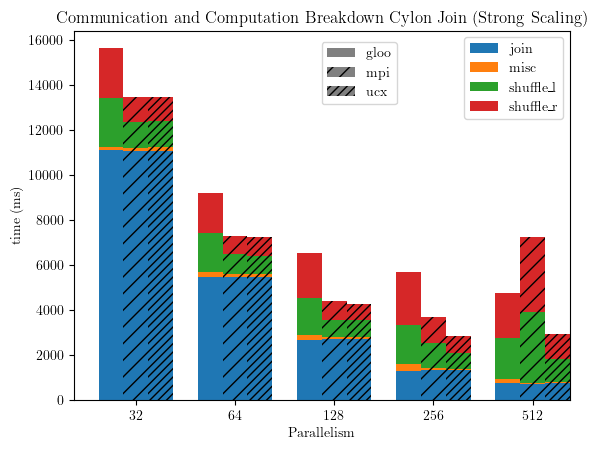

In [95]:
matplotlib.use(default_backend)
cols = ['join', 'misc','shuffle_l','shuffle_r']
plot_clustered_stacked([df11['gloo'][cols], df11['mpi'][cols], df11['ucx'][cols]], 
                       labels=df11.columns.levels[0].values, 
                       title=f"Communication and Computation Breakdown {cylon} Join (Strong Scaling)",
                       backend='matplotlib')
plt.show()

In [94]:
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "xelatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
plot_clustered_stacked([df11['gloo'][cols], df11['mpi'][cols], df11['ucx'][cols]], 
                       labels=df11.columns.levels[0].values, 
                       title=f"Communication and Computation Breakdown {cylon} Join (Strong Scaling)",
                       backend='matplotlib')

plt.savefig(f'{resultsgraphs}/join_comms.pgf')
plt.savefig(f'{resultsgraphs}/join_comms.svg')
plt.savefig(f'{resultsgraphs}/join_comms.png')

matplotlib.use(default_backend)

In [86]:
join_comms = '/home/niranda/Desktop/cylon_results/join_comms_weak.csv'
df = pd.read_csv(join_comms, header=0)
df1 = pd.pivot_table(df, values="time(ms)", index=["Parallelism"], columns=["Comm", "Stage"], aggfunc=np.mean)
df1

Comm                 gloo                                            \
Stage                join     shuffle_l     shuffle_r     shuffle_t   
Parallelism                                                           
32            8427.000000   1792.666667   1767.666667   3560.833333   
64            8520.833333   2688.833333   2610.166667   5299.833333   
128           8514.200000   4905.400000   4137.000000   9043.000000   
256           8937.000000   8748.500000   8812.000000  17561.500000   
512          11274.000000  17465.750000  20779.000000  38245.250000   

Comm                                mpi                            \
Stage          total_time          join    shuffle_l    shuffle_r   
Parallelism                                                         
32           12251.550590   8309.833333   978.666667   810.666667   
64           14036.018313   8453.166667  1565.500000  1392.833333   
128          18147.151394   8504.428571  2582.000000  2385.857143   
256          27363.612630   9187.166667  4910.000000  4802.000000   
512          50403.469747  10949.800000  9582.400000  9270.600000   

Comm                                     
Stage           shuffle_t    total_time  
Parallelism                              
32            1790.000000  10423.292883  
64            2959.166667  11776.531832  
128           4968.571429  13381.566497  
256           9713.000000  17798.603947  
512          18853.600000  29834.200763

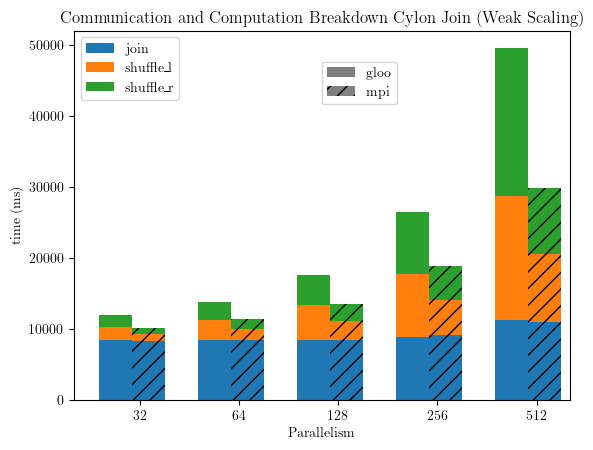

In [92]:
matplotlib.use(default_backend)
cols = ['join','shuffle_l','shuffle_r']
plot_clustered_stacked([df1['gloo'][cols], df1['mpi'][cols]], 
                       labels=df1.columns.levels[0].values, 
                       title=f"Communication and Computation Breakdown {cylon} Join (Weak Scaling)",
                       backend='matplotlib')
plt.show()

In [93]:
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "xelatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
plot_clustered_stacked([df1['gloo'][cols], df1['mpi'][cols]], 
                       labels=df1.columns.levels[0].values, 
                       title=f"Communication and Computation Breakdown {cylon} Join (Weak Scaling)",
                       backend='matplotlib')

plt.savefig(f'{resultsgraphs}/join_comms_weak.pgf')
plt.savefig(f'{resultsgraphs}/join_comms_weak.svg')
plt.savefig(f'{resultsgraphs}/join_comms_weak.png')

matplotlib.use(default_backend)

In [130]:
df1.columns

MultiIndex([('gloo',       'join'),
            ('gloo',  'shuffle_l'),
            ('gloo',  'shuffle_r'),
            ('gloo',  'shuffle_t'),
            ('gloo', 'total_time'),
            ( 'mpi',       'join'),
            ( 'mpi',  'shuffle_l'),
            ( 'mpi',  'shuffle_r'),
            ( 'mpi',  'shuffle_t'),
            ( 'mpi', 'total_time')],
           names=['Comm', 'Stage'])

In [132]:
df11 = df1[[('gloo',       'join'),
            ('gloo',  'shuffle_l'),
            ('gloo',  'shuffle_r'),
            ( 'mpi',       'join'),
            ( 'mpi',  'shuffle_l'),
            ( 'mpi',  'shuffle_r')]]

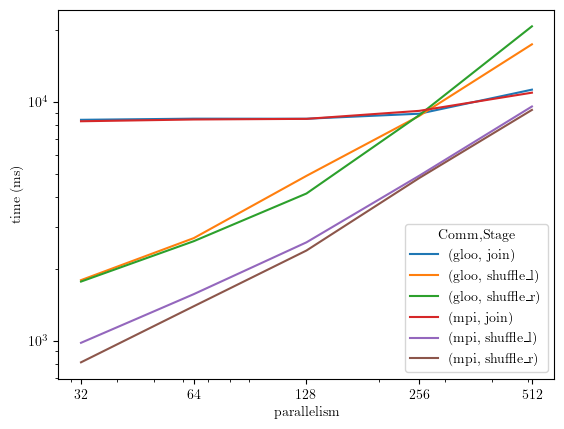

In [135]:
matplotlib.use(default_backend)

ax = df11.plot(loglog=True, xticks=df11.index, xlabel='parallelism',
                   ylabel='time (ms)',)
def scientific(x, pos):
    return f'{x}'

from matplotlib.ticker import FuncFormatter

scientific_formatter = FuncFormatter(scientific)
ax.xaxis.set_major_formatter(scientific_formatter)
plt.show()


matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "xelatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
ax = df11.plot(loglog=True, xticks=df11.index, xlabel='parallelism',
                   ylabel='time (ms)',)
def scientific(x, pos):
    return f'{x}'

from matplotlib.ticker import FuncFormatter
scientific_formatter = FuncFormatter(scientific)
ax.xaxis.set_major_formatter(scientific_formatter)

plt.savefig(f'{resultsgraphs}/join_comms_weak1.svg')
plt.savefig(f'{resultsgraphs}/join_comms_weak1.png')

matplotlib.use(default_backend)

In [155]:
join_comms = '/home/niranda/Desktop/cylon_results/weak-5m.csv'
df = pd.read_csv(join_comms, header=0)
df1 = pd.pivot_table(df, values="time(ms)", index=["Parallelism"], columns=["Comm", "Stage"], aggfunc=np.mean)
df1

Comm                gloo                                                 mpi  \
Stage               join    shuffle_l    shuffle_r    shuffle_t         join   
Parallelism                                                                    
32           1491.833333   859.500000   722.333333  1582.166667  1476.166667   
64           1544.000000  1000.500000   899.000000  1899.833333  1523.166667   
128          1553.833333  1415.666667  1516.833333  2933.500000  1550.166667   
256          1587.166667  2193.666667  2138.333333  4332.166667  1583.333333   
512          1903.333333  3948.666667  4607.333333  8556.666667  1909.333333   

Comm                                                        ucx            \
Stage          shuffle_l    shuffle_r    shuffle_t         join shuffle_l   
Parallelism                                                                 
32            167.000000   159.000000   326.833333  1470.500000     144.0   
64            323.166667   293.333333   617.000000  1494.666667     264.0   
128           552.000000   551.666667  1104.500000  1566.400000     413.2   
256          1362.333333  1296.500000  2659.333333  1584.833333     850.6   
512          3577.166667  3793.833333  7371.666667  1956.600000    2302.4   

Comm                                
Stage       shuffle_r    shuffle_t  
Parallelism                         
32              153.5   298.166667  
64              258.5   523.000000  
128             422.6   836.200000  
256             922.6  1773.400000  
512            2357.6  4660.800000

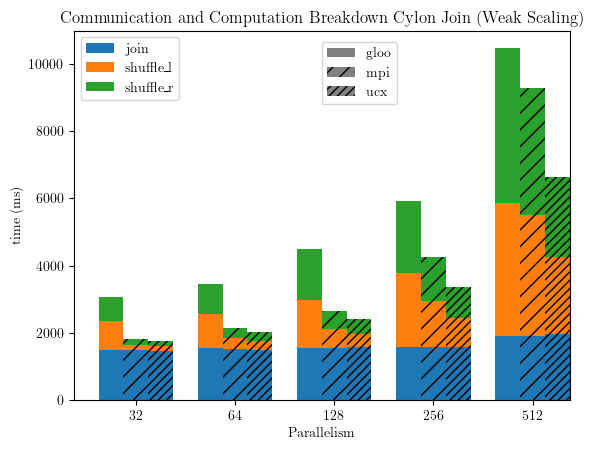

In [157]:
matplotlib.use(default_backend)
cols = ['join','shuffle_l','shuffle_r']
plot_clustered_stacked([df1['gloo'][cols], df1['mpi'][cols], df1['ucx'][cols]], 
                       labels=df1.columns.levels[0].values, 
                       title=f"Communication and Computation Breakdown {cylon} Join (Weak Scaling)",
                       backend='matplotlib')
plt.show()

matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "xelatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
plot_clustered_stacked([df1['gloo'][cols], df1['mpi'][cols], df1['ucx'][cols]], 
                       labels=df1.columns.levels[0].values, 
                       title=f"Communication and Computation Breakdown {cylon} Join (Weak Scaling)",
                       backend='matplotlib')

plt.savefig(f'{resultsgraphs}/join_comms_weak5m.pgf')
plt.savefig(f'{resultsgraphs}/join_comms_weak5m.svg')
plt.savefig(f'{resultsgraphs}/join_comms_weak5m.png')

matplotlib.use(default_backend)

In [5]:
ss = pd.read_csv('/home/niranda/Desktop/cylon_results/summit-strong.csv', header=0)
ss

,Parallelism,Time,min,max
0,168,57014.465160,55641.482920,58511.049060
1,336,24794.888510,24549.073920,25026.955660
2,672,13369.397340,13041.292690,13679.648390
3,1344,7604.210930,7425.376639,7876.667751
4,2688,4640.228776,4576.592625,4770.834707
5,5376,6147.400160,5601.707548,6637.960121
6,10752,10370.176140,8062.104335,10968.225580


In [200]:
sw = pd.read_csv('/home/niranda/Desktop/cylon_results/summit-weak.csv', header=0)
sw

,Parallelism,Time,min,max
0,1,30663.40292,27513.41248,35647.53413
1,42,38030.85642,37158.44291,40509.53668
2,84,45096.62456,43817.88403,46766.17743
3,168,43734.36513,40489.93319,45976.63151
4,336,46031.00155,44315.41030,49076.17597
5,672,48772.10038,47489.65184,50293.03264
6,1344,52463.18266,50219.95287,54940.43571
7,2688,59549.52116,57932.39892,60961.52011
8,5376,70206.13435,69358.73031,71637.24115
9,10752,91004.85400,89971.01998,92022.05127


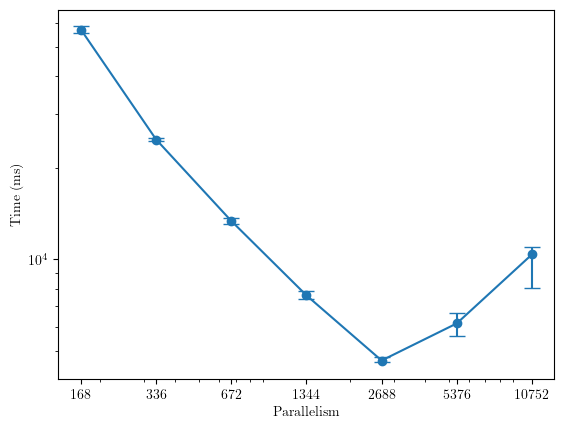

In [29]:
matplotlib.use(default_backend)
def summit_plot(df):
    ax = df.plot(x="Parallelism", y='Time', loglog=True, xticks=df['Parallelism'], xlabel='Parallelism',
                       ylabel='Time (ms)', marker='o',legend=False , yerr=[df['Time']-df['min'],df['max']-df['Time']], capsize=6)
    
    def scientific(x, pos):
        return f'{x}'
    from matplotlib.ticker import FuncFormatter
    ax.xaxis.set_major_formatter(FuncFormatter(scientific))
    return ax

ax = summit_plot(ss)

plt.savefig(f'{resultsgraphs}/summit_strong.svg')
plt.savefig(f'{resultsgraphs}/summit_strong.png')
plt.show()

In [21]:
ss1 = pd.read_csv('/home/niranda/Desktop/cylon_results/summit-strong-big.csv', header=0)
ss1


,Parallelism,Time,min,max
0,1344,35201.26665,34616.56625,35716.28942
1,2688,20105.43061,19666.20234,20692.57998
2,5376,14531.32435,14025.47059,15228.72716
3,10752,12515.36843,11959.60712,13074.98538


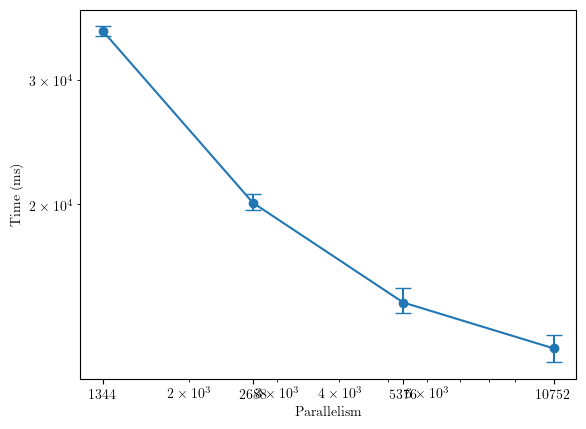

In [42]:
ax = summit_plot(ss1)
# print(ax.get_xticks(minor=True))
# ax.xaxis.minorticks_off()
# ax.set_xticks(ss1['Parallelism'])
plt.savefig(f'{resultsgraphs}/summit_strong-big.svg')
plt.savefig(f'{resultsgraphs}/summit_strong-big.png')
plt.show()

In [10]:
def summit_weak_plot(df):
    ax = summit_plot(df)
    df['Throughput'] = df['Parallelism']*rows*2/df['Time']

    ax1=df[['Parallelism', 'Throughput']].plot(x='Parallelism', ax=ax, secondary_y=True, loglog=True, linestyle=':', legend=False, xticks=df['Parallelism'])
    ax1.xaxis.set_major_formatter(FuncFormatter(scientific))
    ax1.set_ylabel(ylabel='Throughput (Tuples per second)')
    ax.set_xlabel(xlabel='Parallelism')
    
    return ax 

summit_weak_plot(sw[1:].copy())

plt.savefig(f'{resultsgraphs}/summit_weak.svg')
plt.savefig(f'{resultsgraphs}/summit_weak.png')
plt.show()


NameError: name 'sw' is not defined

In [250]:
df = pd.read_csv('/home/niranda/Desktop/cylon_results/op_framework.csv', header=0)
df

,t,world,Normal,Op-pipeline
0,w,32,8985.600000,7318.875000
1,w,64,10388.500000,8153.833333
2,w,128,12367.800000,10429.200000
3,w,256,16696.700000,13655.142860
4,w,512,28863.500000,24997.333330
5,s,32,11419.000000,10082.888890
6,s,64,6197.428571,5439.200000
7,s,128,3802.888889,3163.700000
8,s,256,3290.333333,2716.285714
9,s,512,7029.100000,6863.600000


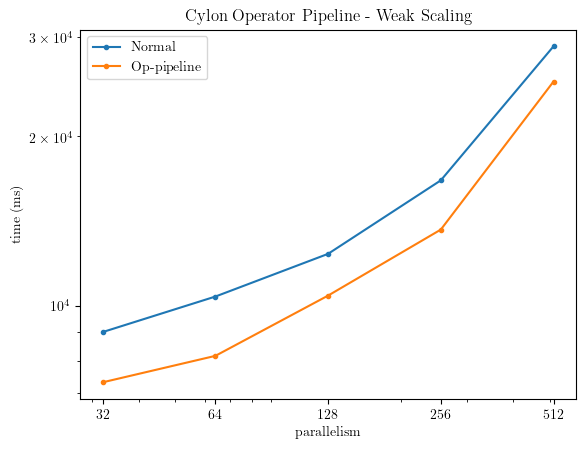

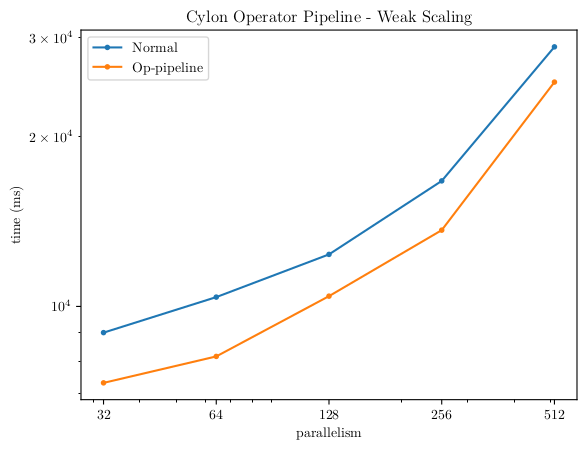

In [252]:
cols = ['world','Normal','Op-pipeline']
weak = df[df['t']=='w'][cols]
weak
plot(weak, f'{resultsgraphs}/op_frame_weak.pgf', f"{cylon} Operator Pipeline - Weak Scaling", True)
plot(weak, f'{resultsgraphs}/op_frame_weak.pgf', f"{cylon} Operator Pipeline - Weak Scaling", False)

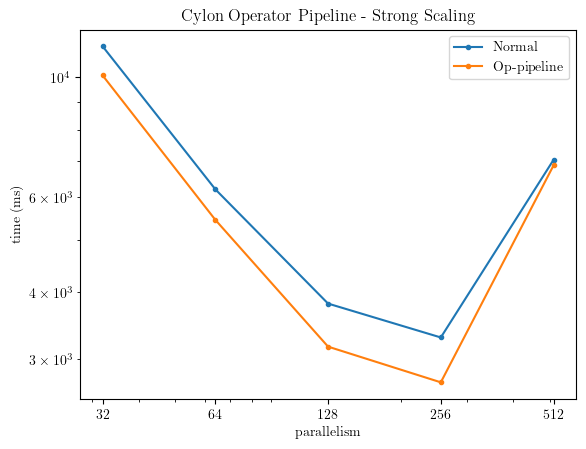

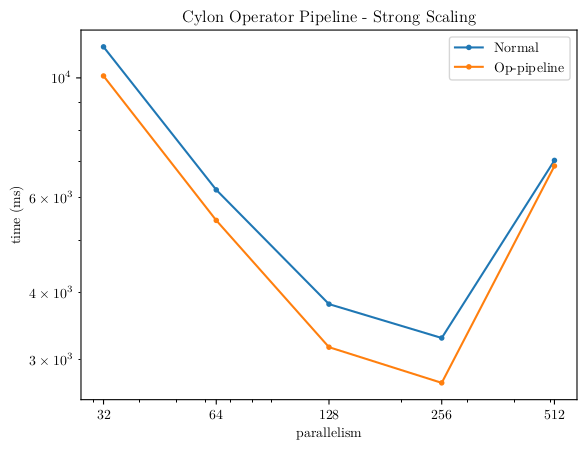

In [254]:
strong = df[df['t']=='s'][cols]
strong
plot(strong, f'{resultsgraphs}/op_frame_strong.pgf', f"{cylon} Operator Pipeline - Strong Scaling", True)
plot(strong, f'{resultsgraphs}/op_frame_strong.pgf', f"{cylon} Operator Pipeline - Strong Scaling", False)

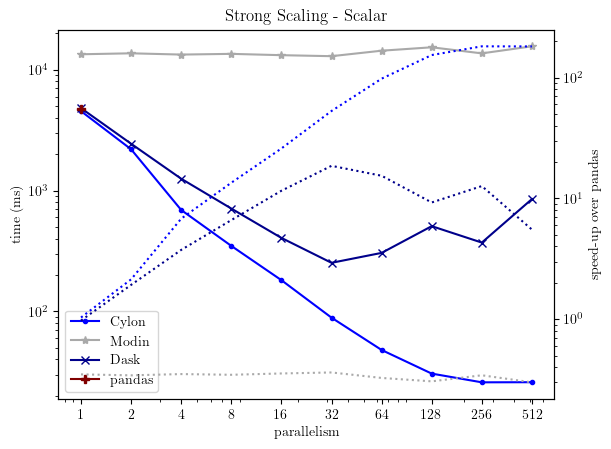

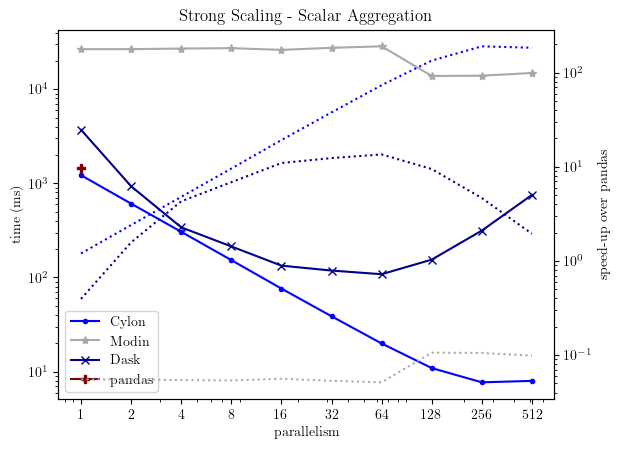

,world,Cylon,Modin,Dask,pandas
0,1,1221.198559,26658.411026,3712.479989,1466.658545
1,2,608.973940,26657.605410,931.465387,NaN
2,4,305.960596,27051.301003,341.097991,NaN
3,8,153.068423,27322.705030,213.847081,NaN
4,16,76.272060,26188.110828,133.646250,NaN
5,32,38.741348,27551.301718,118.507544,NaN
6,64,19.912666,28573.608875,108.361642,NaN
7,128,10.909849,13831.855774,154.821634,NaN
8,256,7.697381,13932.038307,315.026919,NaN
9,512,7.971556,14873.846054,753.602346,NaN


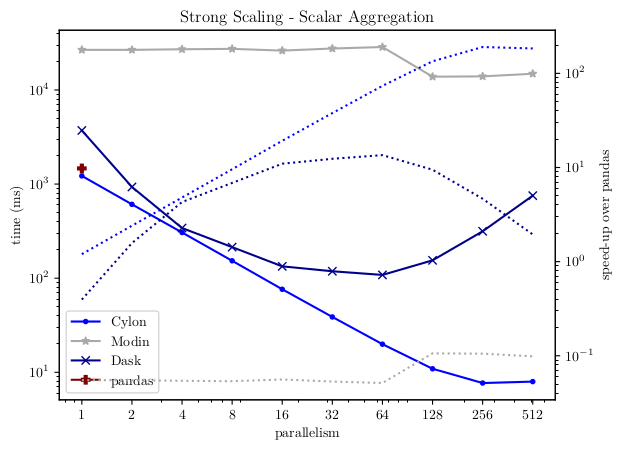

In [48]:
def process_scalar(cy, mod, dask, pandas_, sp, title, out_file, rows, just_show=False):
    cylon_df = pd.read_csv(cy, comment='#')
    modin_df = pd.read_csv(mod, comment='#')
    dask_df = pd.read_csv(dask, comment='#')
    pd_df = pd.read_csv(pandas_, comment='#')
    spark_df = pd.read_csv(sp, comment='#')

    cylon_avg = sqldf(
        f"SELECT world, avg(time) as avg FROM cylon_df WHERE rows={rows} AND tag like '%c=mpi%' AND it!=0 GROUP BY world ORDER BY world", locals())
    modin_avg = sqldf(
        f"SELECT world, avg(time) as avg FROM modin_df WHERE rows={rows} AND it!=0 GROUP BY world ORDER BY world", locals())
    dask_avg = sqldf(
        f"SELECT world, avg(time) as avg FROM dask_df WHERE rows={rows} AND it!=0 GROUP BY world ORDER BY world", locals())

    data = sqldf(f"""SELECT cy.world, cy.avg AS {cylon}, md.avg AS Modin, da.avg as Dask
        FROM cylon_avg cy JOIN modin_avg md ON cy.world = md.world
        JOIN dask_avg da ON da.world = cy.world""", locals())

    pd_avg = sqldf(
        f"SELECT world, avg(time) as avg FROM pd_df WHERE rows={rows} GROUP BY world", locals())
    l = [None for _ in range(len(data))]
    l[0] = pd_avg['avg'][0]
    data['pandas'] = l
    
    speed_up_data = None
    speed_up_data = l[0]/ data[[cylon, 'Modin', 'Dask',]]
    speed_up_data['world'] = data['world']
    # speed_up_data = l[0]/ data[[cylon, 'Modin', 'Dask', 'Spark']]
    # speed_up_data['world'] = data['world']

    plot(data, out_file, title, True, colors=colors, speedup=speed_up_data)
    plot(data, out_file, title, False, colors=colors, speedup=speed_up_data)
    
    return data 

just_show = False

process_scalar(f'{data_dir}/scalar.csv', f'{data_dir}/modin_scalar.csv',
               f'{data_dir}/dask_scalar.csv',
               f'{data_dir}/pandas_scalar.csv', 
               f'{data_dir}/spark_scalar.csv', 
               'Strong Scaling - Scalar',
               f'{resultsgraphs}/scalar_ppam.pgf', 1000000000, just_show)
process_scalar(f'{data_dir}/scalar-agg.csv', f'{data_dir}/modin_scalar_agg.csv',
               f'{data_dir}/dask_scalar_agg.csv',
               f'{data_dir}/pandas_scalar_agg.csv',
               f'{data_dir}/spark_scalar_agg.csv', 
               'Strong Scaling - Scalar Aggregation',
               f'{resultsgraphs}/scalar-agg_ppam.pgf', 1000000000, just_show)

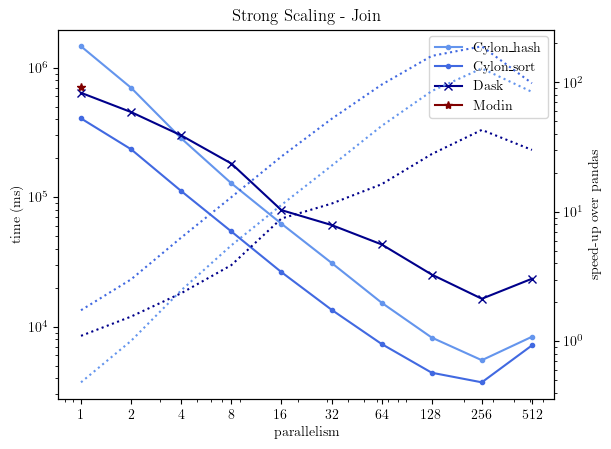

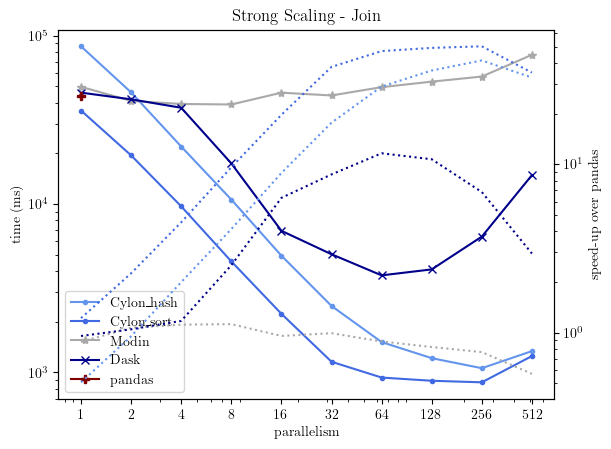

,world,Cylon_hash,Cylon_sort,Modin,Dask,pandas
0,1,86508.634197,35955.641508,49751.359463,45914.642215,43807.772636
1,2,46067.080366,19470.111797,40994.780064,41901.000321,NaN
2,4,21965.075129,9695.878034,39327.589750,37341.491878,NaN
3,8,10637.190806,4567.248677,39042.614460,17445.756674,NaN
4,16,4938.266269,2229.684319,45885.592937,6938.918209,NaN
5,32,2482.377859,1157.323117,44175.829649,5035.581732,NaN
6,64,1514.591127,932.404771,49488.513470,3772.268438,NaN
7,128,1215.547123,892.309846,53364.571571,4093.422270,NaN
8,256,1059.867303,873.543363,57217.237234,6409.523249,NaN
9,512,1338.252703,1251.473340,77025.178194,14857.713652,NaN


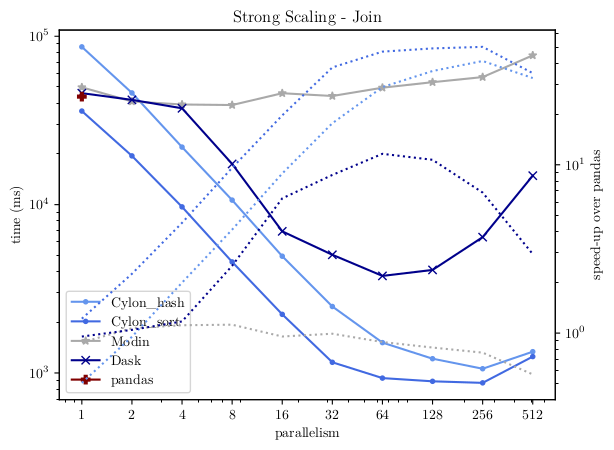

In [52]:
def process_join(cy, mod, dask, spark, pandas_, title, out_file, rows, just_show=False):
    cylon_df = pd.read_csv(cy, comment='#')
    modin_df = pd.read_csv(mod, comment='#')
    dask_df = pd.read_csv(dask, comment='#')
    spark_df = pd.read_csv(spark, comment='#')

    cylon_hash_avg = sqldf(
        f"SELECT world, avg(time) as avg FROM cylon_df WHERE rows={rows} AND tag like '%a=hash u=0.9 c=mpi%' AND it!=0 GROUP BY world",
        locals())
    cylon_sort_avg = sqldf(
        f"SELECT world, avg(time) as avg FROM cylon_df WHERE rows={rows} AND tag like '%a=sort u=0.9 c=mpi%' AND it!=0 GROUP BY world",
        locals())
    modin_avg = sqldf(
        f"SELECT world, avg(time) as avg FROM modin_df WHERE rows={rows} AND it!=0 GROUP BY world", locals())
    dask_avg = sqldf(
        f"SELECT world, avg(time) as avg FROM dask_df WHERE rows={rows} AND it!=0 GROUP BY world", locals())
    

    if len(modin_avg):
        data = sqldf(f"""SELECT cy.world, cy.avg AS {cylon}_hash, cys.avg as {cylon}_sort, md.avg AS Modin, da.avg as Dask
          FROM cylon_hash_avg cy 
          JOIN cylon_sort_avg cys ON cy.world = cys.world
          JOIN modin_avg md ON cy.world = md.world
          JOIN dask_avg da ON da.world = cy.world
          """, locals())
    else:
        data = sqldf(f"""SELECT cy.world, cy.avg AS {cylon}_hash, cys.avg as {cylon}_sort, da.avg as Dask 
          FROM cylon_hash_avg cy 
          JOIN cylon_sort_avg cys ON cy.world = cys.world
          JOIN dask_avg da ON da.world = cy.world
          """, locals())
        data['Modin'] = [None for _ in range(len(data))]
    
    pd_df = pd.read_csv(pandas_, comment='#')
    pd_avg = sqldf(
        f"SELECT world, avg(time) as avg FROM pd_df WHERE rows={rows} GROUP BY world", locals())
    l = [None for _ in range(len(data))]
    l[0] = pd_avg['avg'][0]
    data['pandas'] = l
    
    speed_up_data = None
    # speed_up_data = l[0]/ data[[f'{cylon}_sort', f'{cylon}_hash']]
    speed_up_data = l[0]/ data[[f'{cylon}_sort', f'{cylon}_hash', 'Modin', 'Dask']]
    speed_up_data['world'] = data['world']
    
    # {f'{cylon}_sort': 'royalblue', f'{cylon}_hash': 'cornflowerblue', 'modin': 'orange',
        # 'dask': 'green', 'pandas': 'maroon', 'spark': 'purple'}
    plot(data, out_file, title, True, colors=colors, speedup=speed_up_data)
    plot(data, out_file, title, False, colors=colors, speedup=speed_up_data)
    
    return data

process_join(f'{data_dir}/join.csv', 
             f'{data_dir}/modin_join.csv',
             f'{data_dir}/dask_join.csv',
             f'{data_dir}/spark_join.csv',
             f'{data_dir}/pandas_join.csv', 
             'Strong Scaling - Join',
             f'{resultsgraphs}/join1B_ppam.pgf', 1000000000, None)
process_join(f'{data_dir}/join.csv', 
             f'{data_dir}/modin_join.csv',
             f'{data_dir}/dask_join.csv',
             f'{data_dir}/spark_join.csv',
             f'{data_dir}/pandas_join.csv', 
             'Strong Scaling - Join',
             f'{resultsgraphs}/join100M_ppam.pgf', 100000000, None)

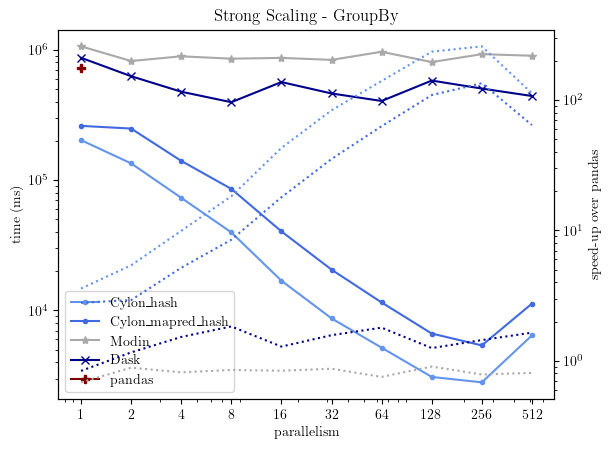

,world,Cylon_hash,Cylon_mapred_hash,Modin,Dask,pandas
0,1,202661.834038,260672.506843,1.062215e+06,867792.817146,726710.740507
1,2,134376.259191,248568.720545,8.194281e+05,626467.576057,NaN
2,4,73156.346372,140490.461988,8.904780e+05,476520.910025,NaN
3,8,39721.903247,85592.544360,8.539766e+05,395927.389145,NaN
4,16,16916.937158,40436.527391,8.659070e+05,565002.696991,NaN
5,32,8698.396732,20573.009912,8.359693e+05,461991.052945,NaN
6,64,5182.065584,11521.265810,9.646933e+05,404526.781480,NaN
7,128,3091.593603,6654.251071,8.042046e+05,580021.078587,NaN
8,256,2811.534861,5394.329346,9.249890e+05,503697.638512,NaN
9,512,6440.074470,11290.019295,8.995566e+05,441801.900387,NaN


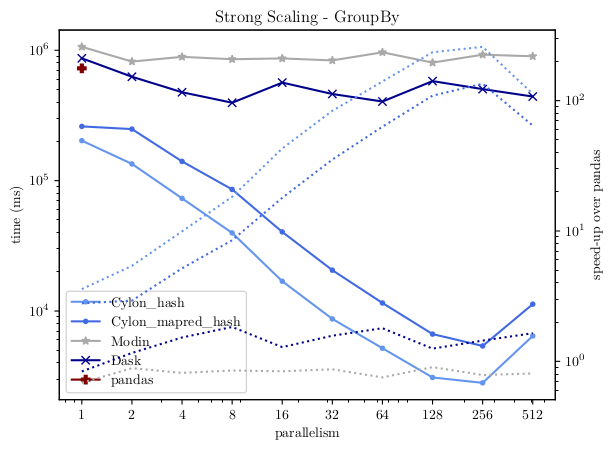

In [53]:
def process_groupby(cy, mod, dask, spark, pandas_, title, out_file, rows, just_show=False):
    cylon_df = pd.read_csv(cy, comment='#')
    modin_df = pd.read_csv(mod, comment='#')
    dask_df = pd.read_csv(dask, comment='#')

    cylon_hash_avg = sqldf(f"SELECT world, avg(time) as avg FROM cylon_df WHERE rows={rows} AND tag like '%a=hash u=0.9 c=mpi%' AND it!=0 GROUP BY world", locals())
    cylon_sort_avg = sqldf(f"SELECT world, avg(time) as avg FROM cylon_df WHERE rows={rows} AND tag like '%a=mapred_hash u=0.9 c=mpi%' AND it!=0 GROUP BY world",  locals())
    modin_avg = sqldf(f"SELECT world, avg(time) as avg FROM modin_df WHERE rows={rows} AND it!=0 GROUP BY world", locals())
    dask_avg = sqldf(f"SELECT world, avg(time) as avg FROM dask_df WHERE rows={rows} AND it!=0 GROUP BY world", locals())

    data = sqldf(f"""SELECT cy.world, cy.avg AS {cylon}_hash, cys.avg as {cylon}_mapred_hash, md.avg AS Modin, da.avg as Dask 
        FROM cylon_hash_avg cy 
        JOIN cylon_sort_avg cys ON cy.world = cys.world
        LEFT JOIN modin_avg md ON cy.world = md.world
        JOIN dask_avg da ON da.world = cy.world
        """, locals())

    if len(modin_avg) == 0:
        data.drop(columns='Modin', inplace=True)
    
    pd_df = pd.read_csv(pandas_, comment='#')
    pd_avg = sqldf(
        f"SELECT world, avg(time) as avg FROM pd_df WHERE rows={rows} GROUP BY world", locals())
    l = [None for _ in range(len(data))]
    l[0] = pd_avg['avg'][0]
    data['pandas'] = l
    
    speed_up_data = None
    # speed_up_data = l[0]/ data[[f'{cylon}_hash', f'{cylon}_mapred_hash']]
    speed_up_data = l[0]/ data[[f'{cylon}_hash', f'{cylon}_mapred_hash', 'Modin', 'Dask']]
    speed_up_data['world'] = data['world']

    # colors_ = {
    #     f'{cylon}_hash': 'royalblue', f'{cylon}_mapred_hash': 'cornflowerblue', 'modin': 'orange',
    #     'dask': 'green', 'pandas': 'maroon'}
    plot(data, out_file, title, True, colors=colors, speedup=speed_up_data)
    plot(data, out_file, title, False, colors=colors, speedup=speed_up_data)
    
    return data
    
process_groupby(f'{data_dir}/groupby.csv', f'{data_dir}/modin_groupby.csv',
                f'{data_dir}/dask_groupby.csv', 
                f'{data_dir}/spark_groupby.csv', 
                f'{data_dir}/pandas_groupby.csv',
                'Strong Scaling - GroupBy', f'{resultsgraphs}/groupby_ppam.pgf',
                1000000000, just_show)

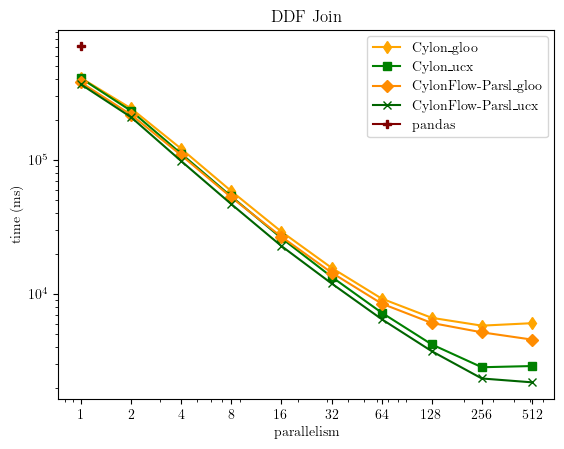

,world,Cylon_gloo,Cylon_ucx,CylonFlow-Parsl_gloo,CylonFlow-Parsl_ucx,pandas
0,1,409185.396115,406717.762709,378866.306250,366595.206250,705125.56994
1,2,242424.797336,232498.086333,217700.143750,208588.178125,NaN
2,4,121240.434905,111381.250282,108481.120313,98122.295313,NaN
3,8,58566.811552,53434.789737,52580.192969,46838.385938,NaN
4,16,29187.274352,26127.413779,26744.203906,22805.262891,NaN
5,32,15686.577188,13442.369895,14443.360547,11994.192188,NaN
6,64,9242.033334,7255.364296,8480.657031,6492.678711,NaN
7,128,6640.439497,4205.688692,6078.691309,3742.639795,NaN
8,256,5803.891781,2840.025144,5173.794141,2341.307159,NaN
9,512,6053.764271,2898.938821,4567.566699,2191.654449,NaN


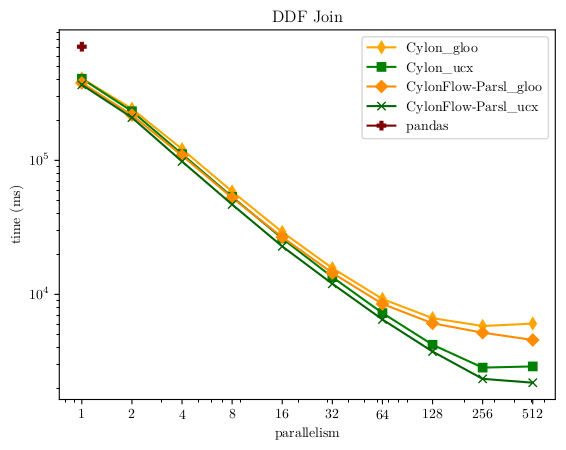

In [12]:
# def process_join_comms(cy, mod, dask, pandas_, title, out_file, rows, just_show=False):
def cflow_join(title, out_file, rows,op = 'join', algo='sort'):
    cdf = pd.read_csv(f'{data_dir}/{op}.csv', comment='#')
    cflowparsl = pd.read_csv(f'{data_dir}/cylon_parsl_{op}.csv', comment='#')

    df0 = sqldf(
        f"SELECT world, avg(time) as avg FROM cdf WHERE rows={rows} AND tag like '%a={algo} u=0.9 c=gloo%' AND it!=0 GROUP BY world ORDER BY world", locals())
    df1 = sqldf(
        f"SELECT world, avg(time) as avg FROM cdf WHERE rows={rows} AND tag like '%a={algo} u=0.9 c=ucx%' AND it!=0 GROUP BY world ORDER BY world", locals())
    df2 = sqldf(
        f"SELECT world, avg(time) as avg FROM cflowparsl WHERE rows={rows} AND tag like '%a={algo} u=0.9 c=gloo%' AND it!=0 GROUP BY world ORDER BY world", locals())
    df3 = sqldf(
        f"SELECT world, avg(time) as avg FROM cflowparsl WHERE rows={rows} AND tag like '%a={algo}%c=ucx%' AND it!=0 GROUP BY world ORDER BY world", locals())
    
    data=pd.concat([df0, df1['avg'], df2['avg'], df3['avg']], axis=1)
    data.columns=['world',f'{cylon}_gloo', f'{cylon}_ucx', f'{cflow}-Parsl_gloo', f'{cflow}-Parsl_ucx']

    pd_df = pd.read_csv(f'{data_dir}/pandas_{op}.csv', comment='#')
    pd_avg = sqldf(
        f"SELECT world, avg(time) as avg FROM pd_df WHERE rows={rows} GROUP BY world", locals())
    l = [None for _ in range(len(data))]
    l[0] = pd_avg['avg'][0]
    data['pandas'] = l
    
    plot(data, out_file, title, True, colors=colors)
    
    plot(data, out_file, title, False, colors=colors)
    
    return data


cflow_join(f'DDF Join', f'{resultsgraphs}/cflow_parsl_join.pgf', 1000000000)

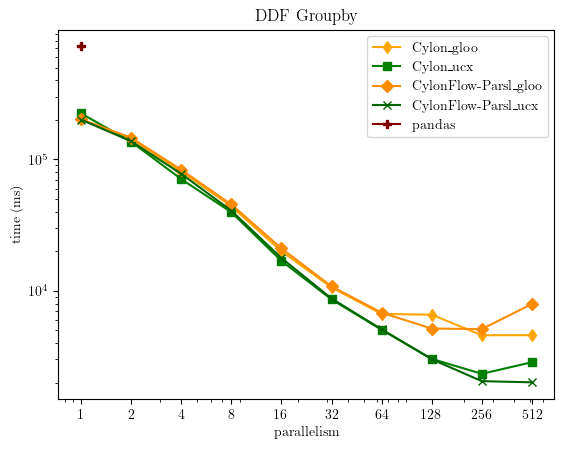

,world,Cylon_gloo,Cylon_ucx,CylonFlow-Parsl_gloo,CylonFlow-Parsl_ucx,pandas
0,1,202413.766623,224135.021687,202334.741071,201018.941964,726710.740507
1,2,143527.668079,136604.720632,146272.470982,137618.080357,NaN
2,4,81217.897117,70841.748675,83556.636161,77775.034598,NaN
3,8,44011.412352,39676.487873,45450.308036,40739.664062,NaN
4,16,19982.865577,16888.182804,21020.519531,17760.152344,NaN
5,32,10620.938356,8595.104573,10804.241071,8727.507673,NaN
6,64,6662.978447,5049.458324,6815.275530,5091.534389,NaN
7,128,6575.643279,3031.805984,5158.408273,3014.071603,NaN
8,256,4588.388373,2332.076762,5111.999337,2050.618495,NaN
9,512,4591.815310,2858.315353,7931.869210,2009.518188,NaN


In [15]:
def cflow_parsl(title, out_file, rows, op = 'groupby', algo = 'hash'):
    
    cdf = pd.read_csv(f'{data_dir}/{op}.csv', comment='#')
    cflowparsl = pd.read_csv(f'{data_dir}/cylon_parsl_{op}.csv', comment='#')

    df0 = sqldf(
        f"SELECT world, avg(time) as avg FROM cdf WHERE rows={rows} AND tag like '%a={algo} u=0.9 c=gloo%' AND it!=0 GROUP BY world ORDER BY world", locals())
    df1 = sqldf(
        f"SELECT world, avg(time) as avg FROM cdf WHERE rows={rows} AND tag like '%a={algo} u=0.9 c=ucx%' AND it!=0 GROUP BY world ORDER BY world", locals())
    df2 = sqldf(
        f"SELECT world, avg(time) as avg FROM cflowparsl WHERE rows={rows} AND tag like '%a={algo} u=0.9 c=gloo%' AND it!=0 GROUP BY world ORDER BY world", locals())
    df3 = sqldf(
        f"SELECT world, avg(time) as avg FROM cflowparsl WHERE rows={rows} AND tag like '%a={algo} u=0.9 c=ucx%' AND it!=0 GROUP BY world ORDER BY world", locals())
 
    
    data=pd.concat([df0, df1['avg'], df2['avg'], df3['avg']], axis=1)
    data.columns=['world',f'{cylon}_gloo', f'{cylon}_ucx', f'{cflow}-Parsl_gloo', f'{cflow}-Parsl_ucx']


    pd_df = pd.read_csv(f'{data_dir}/pandas_{op}.csv', comment='#')
    pd_avg = sqldf(
        f"SELECT world, avg(time) as avg FROM pd_df WHERE rows={rows} GROUP BY world", locals())
    if len(pd_avg):
        l = [None for _ in range(len(data))]
        l[0] = pd_avg['avg'][0]
        data['pandas'] = l
    
    # print(data)
    plot(data, out_file, title, False, colors=colors)
    plot(data, out_file, title, True, colors=colors)
    
    return data


cflow_parsl(f'DDF Groupby', f'{resultsgraphs}/cflow_parsl_groupby.pgf', 1000000000)

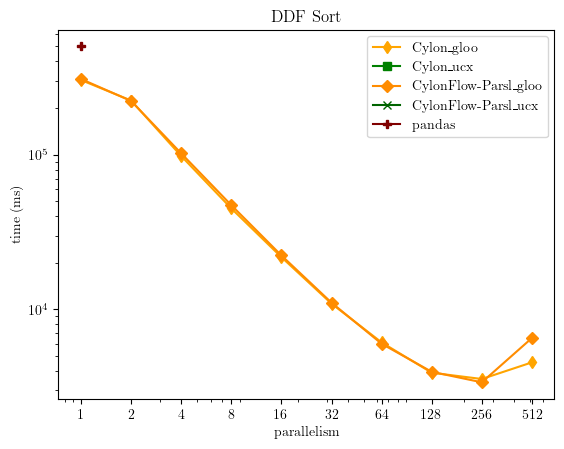

,world,Cylon_gloo,Cylon_ucx,CylonFlow-Parsl_gloo,CylonFlow-Parsl_ucx,pandas
0,1,303415.500641,NaN,308325.678571,NaN,501213.823318
1,2,223674.504360,NaN,222183.540179,NaN,NaN
2,4,97927.002430,NaN,101915.227679,NaN,NaN
3,8,44905.778925,NaN,47135.703125,NaN,NaN
4,16,21744.979893,NaN,22309.330636,NaN,NaN
5,32,10887.486922,NaN,11047.212612,NaN,NaN
6,64,6117.146943,NaN,5995.167201,NaN,NaN
7,128,3894.464890,NaN,3949.938058,NaN,NaN
8,256,3548.630017,NaN,3377.181083,NaN,NaN
9,512,4543.361607,NaN,6529.922886,NaN,NaN


In [ ]:
cflow_parsl(f'DDF Sort', f'{resultsgraphs}/cflow_parsl_sort.pgf', 1000000000, 'sort', 'initial')

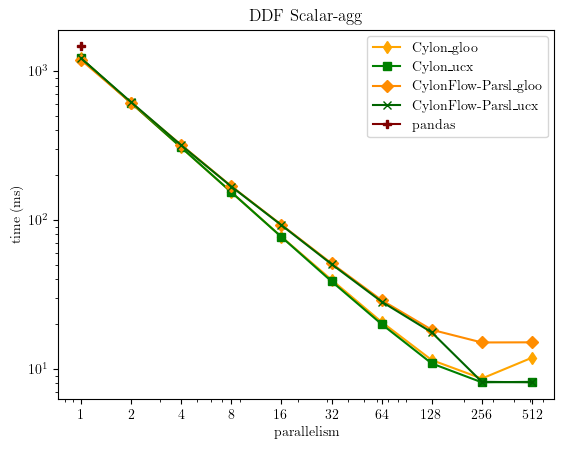

,world,Cylon_gloo,Cylon_ucx,CylonFlow-Parsl_gloo,CylonFlow-Parsl_ucx,pandas
0,1,1221.428951,1219.803333,1187.531285,1218.284424,1466.658545
1,2,609.906157,610.920191,612.047939,618.072048,NaN
2,4,306.661884,306.893905,319.325653,317.385114,NaN
3,8,153.801372,153.697183,168.451168,167.724023,NaN
4,16,77.112138,76.891462,92.823467,92.267034,NaN
5,32,39.624934,38.680544,51.121338,50.473603,NaN
6,64,20.627420,19.947641,28.906482,28.249168,NaN
7,128,11.445640,10.862838,18.286009,17.566698,NaN
8,256,8.599305,8.111628,15.028111,8.173729,NaN
9,512,11.866500,8.170191,15.059921,8.112923,NaN


In [21]:
def cflow_parsl_agg(title, out_file, rows, op = 'scalar_agg', algo = 'hash'):
    
    cdf = pd.read_csv(f'{data_dir}/{op}.csv', comment='#')
    cflowparsl = pd.read_csv(f'{data_dir}/cylon_parsl_{op}.csv', comment='#')

    df0 = sqldf(
        f"SELECT world, avg(time) as avg FROM cdf WHERE rows={rows} AND tag like '%u=0.9 c=gloo%' AND it!=0 GROUP BY world ORDER BY world", locals())
    df1 = sqldf(
        f"SELECT world, avg(time) as avg FROM cdf WHERE rows={rows} AND tag like '%u=0.9 c=ucx%' AND it!=0 GROUP BY world ORDER BY world", locals())
    df2 = sqldf(
        f"SELECT world, avg(time) as avg FROM cflowparsl WHERE rows={rows} AND tag like '%u=0.9 c=gloo%' AND it!=0 GROUP BY world ORDER BY world", locals())
    df3 = sqldf(
        f"SELECT world, avg(time) as avg FROM cflowparsl WHERE rows={rows} AND tag like '%u=0.9 c=ucx%' AND it!=0 GROUP BY world ORDER BY world", locals())
 
    
    data=pd.concat([df0, df1['avg'], df2['avg'], df3['avg']], axis=1)
    data.columns=['world',f'{cylon}_gloo', f'{cylon}_ucx', f'{cflow}-Parsl_gloo', f'{cflow}-Parsl_ucx']


    pd_df = pd.read_csv(f'{data_dir}/pandas_{op}.csv', comment='#')
    pd_avg = sqldf(
        f"SELECT world, avg(time) as avg FROM pd_df WHERE rows={rows} GROUP BY world", locals())
    if len(pd_avg):
        l = [None for _ in range(len(data))]
        l[0] = pd_avg['avg'][0]
        data['pandas'] = l
    
    # print(data)
    plot(data, out_file, title, False, colors=colors)
    plot(data, out_file, title, True, colors=colors)
    
    return data


cflow_parsl_agg(f'DDF Scalar-agg', f'{resultsgraphs}/cflow_parsl_scalar_agg.pgf', 1000000000)

In [60]:
df = pd.read_csv('/home/niranda/Desktop/cylon_results/cylon_tw2.csv', header=0).set_index('world')
df = df.reindex(sorted(df.columns), axis=1)
df

,Cylon Hash,Cylon Sort,Tw2 Hash (Chain) Disk,Tw2 Hash (Chain) Mem,Tw2 Sort (Chain) Disk,Tw2 Sort (Chain) Mem,Tw2 Sort (Simple) Mem
world,,,,,,,
1000000000,6.633254,3.749227,54.162333,42.091000,63.087000,35.2655,38.752667
2000000000,13.577396,7.278827,80.303000,60.065333,78.526667,56.6670,52.450667
4000000000,27.989354,14.183908,158.873000,147.320000,134.200000,114.3570,116.706000
8000000000,79.264050,29.218887,323.043000,739.630000,252.350000,624.9710,NaN


In [42]:
df.columns

Index(['Tw2 Simple Sort Mem', 'Tw2 Chain Hash Mem', 'Tw2 Chain Hash Disk',
       'Tw2 Chain Sort Mem', 'Tw2 Chain Sort Disk', 'Cylon Hash',
       'Cylon Sort'],
      dtype='object')

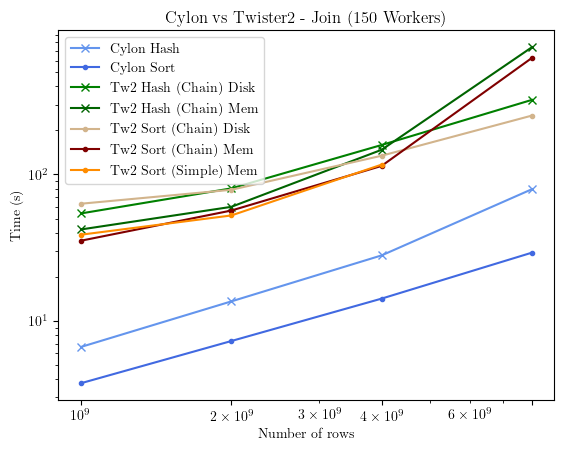

In [86]:
colors_ = {f'{cylon} Sort': 'royalblue', 
          f'{cylon} Hash': 'cornflowerblue',
          'Tw2 Sort (Simple) Mem': 'darkorange', 
          'Tw2 Hash (Chain) Mem': 'darkgreen', 
          'Tw2 Sort (Chain) Mem': 'maroon', 
          'Tw2 Hash (Chain) Disk': 'green', 
          'Tw2 Sort (Chain) Disk': 'tan'}

markers={f'{cylon} Sort': '.', 
          f'{cylon} Hash': 'x',
          'Tw2 Sort (Simple) Mem': '.', 
          'Tw2 Hash (Chain) Mem': 'x', 
          'Tw2 Sort (Chain) Mem': '.', 
          'Tw2 Hash (Chain) Disk': 'x', 
          'Tw2 Sort (Chain) Disk': '.'}

# ax = df.plot.bar(rot=0, logy=True, ylabel='Time (s)', width=0.9, title="Cylon vs Twister2 - Join (150 Workers)", color=colors_)
ax = df.plot(rot=0, loglog=True, xlabel='Number of rows', ylabel='Time (s)', title="Cylon vs Twister2 - Join (150 Workers)", color=colors_)
# ax.xaxis.set_major_formatter(scientific_formatter)

cols = df.columns
for i, line in enumerate(ax.get_lines()): 
    line.set_marker(markers[cols[i]])

ax.set_xticks(df.index)

ax.legend(ax.get_lines(), cols, loc='best')

plt.savefig(f'{resultsgraphs}/cylon_tw2.svg')
